# We will try tracking the hands with just 6 landmarks, which will be a 6 x 3 x 2 = 36 length vector for each time step. 

In [75]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [76]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give 6 landmarks"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence) # MAKE SURE THIS IS ALL GOOD 
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 12
    Y_locations = [0] * 12
    Z_locations = [0] * 12

    if results.multi_hand_landmarks:
        x = y = z = 0 
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                if i not in [0, 4, 8, 12, 16, 20]: continue 
                landmark = hand_landmark.landmark[i]
                X_locations[x] = landmark.x
                Y_locations[y] = landmark.y 
                Z_locations[z] = landmark.z
                x += 1; y += 1; z +=1; 
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [77]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [78]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)
from tensorflow.keras.callbacks import ReduceLROnPlateau

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :12] 
        Y_locations = X[:,  12:24] 
        Z_locations = X[:, 24:]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:,  12:24].assign(X[:,  12:24] + mask * tf.ones_like(X[:,  12:24]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:,  12:24].assign(X[:,  12:24] - mask * tf.ones_like(X[:,  12:24]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :12].assign(X[:, :12] + mask * tf.ones_like(X[:, :12]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :12].assign(X[:, :12] - mask * tf.ones_like(X[:, :12]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move far
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 24:].assign(X[:, 24:] + mask * tf.ones_like(X[:, 24:]) * move_far)
        else: 
            # move close 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 24:].assign(X[:, 24:] - mask * tf.ones_like(X[:, 24:]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  
        

In [144]:
import pickle
import os
import numpy as np 

X = []
y = []

for file in os.listdir('six_point_folds'): 
    with open(f"six_point_folds/{file}", 'rb') as f: 
        X_i, y_i = pickle.load(f)
        X.append(X_i)
        y.append(y_i)

X = np.array(X)
y = np.array(y)

In [80]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 36))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [81]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [138]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (With Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (With Aug)")
    plt.show()

In [103]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(X.shape[0]): 
        model = make_model()

        X_test, y_test = X[i], y[i]
        X_train = np.concatenate([X_j for j, X_j in enumerate(X) if i != j])
        y_train = np.concatenate([y_j for j, y_j in enumerate(y) if i != j])

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 

        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [84]:
# don't shuffle  

"""import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(X, y, seed = 90)"""

'import random \ndef shuffle(X, y, seed = None):\n    if seed == None:  \n        seed = random.randrange(0, 100)\n        print(f"using seed {seed}")\n    np.random.seed(seed) \n    new_X = np.concatenate([X_i for X_i in X])\n    new_y = np.concatenate([y_i for y_i in y])\n    N = np.random.permutation(new_X.shape[0])\n    new_X = new_X[N]\n    new_y = new_y[N]\n    new_X = new_X.reshape(5, 20, 90, 36)\n    new_y = new_y.reshape(5, 20)\n    return new_X, new_y\n\nX, y = shuffle(X, y, seed = 90)'

In [85]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [119]:
def make_model(): 
    model = tf.keras.models.Sequential([
        Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 36)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

In [89]:
original_X = X
original_Y = y 

In [97]:
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 36)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y

X, y = shuffle(original_X, original_Y, seed=65)

Epoch 1/75
3/3 [==============================] - 2s 442ms/step - loss: 0.6930 - accuracy: 0.6125 - precision_274: 0.5870 - recall_274: 0.6923 - val_loss: 0.6171 - val_accuracy: 0.7000 - val_precision_274: 0.7778 - val_recall_274: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 384ms/step - loss: 0.6387 - accuracy: 0.6750 - precision_274: 0.6757 - recall_274: 0.6410 - val_loss: 0.5553 - val_accuracy: 0.7000 - val_precision_274: 0.7778 - val_recall_274: 0.6364
Epoch 3/75
3/3 [==============================] - 1s 383ms/step - loss: 0.6219 - accuracy: 0.6625 - precision_274: 0.6500 - recall_274: 0.6667 - val_loss: 0.5637 - val_accuracy: 0.7500 - val_precision_274: 1.0000 - val_recall_274: 0.5455
Epoch 4/75
3/3 [==============================] - 1s 481ms/step - loss: 0.6061 - accuracy: 0.7125 - precision_274: 0.7667 - recall_274: 0.5897 - val_loss: 0.6076 - val_accuracy: 0.6500 - val_precision_274: 0.8333 - val_recall_274: 0.4545
Epoch 5/75
3/3 [==============================] 

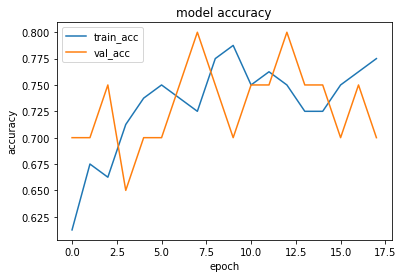

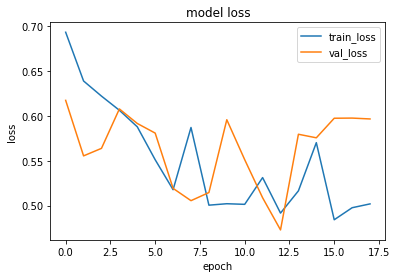

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5004854]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.6355816]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_2.mov is [[0.6290394]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.35519668]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.3095258]]


1it [00:00, 16844.59it/s]


prediction for video control_3.mov is [[0.2945892]]
Epoch 1/75
3/3 [==============================] - 1s 363ms/step - loss: 0.6913 - accuracy: 0.5750 - precision_275: 0.5439 - recall_275: 0.7949 - val_loss: 0.6345 - val_accuracy: 0.7500 - val_precision_275: 0.8000 - val_recall_275: 0.7273
Epoch 2/75
3/3 [==============================] - 1s 354ms/step - loss: 0.6640 - accuracy: 0.6000 - precision_275: 0.8889 - recall_275: 0.2051 - val_loss: 0.5895 - val_accuracy: 0.7000 - val_precision_275: 0.7273 - val_recall_275: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 383ms/step - loss: 0.6167 - accuracy: 0.7625 - precision_275: 0.7778 - recall_275: 0.7179 - val_loss: 0.5556 - val_accuracy: 0.7500 - val_precision_275: 0.7500 - val_recall_275: 0.8182
Epoch 4/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6086 - accuracy: 0.7125 - precision_275: 0.6818 - recall_275: 0.7692 - val_loss: 0.5512 - val_accuracy: 0.7500 - val_precision_275: 0.7500 - val_recall_275: 0.8

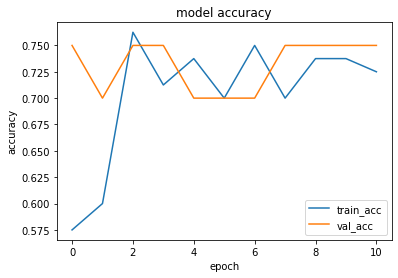

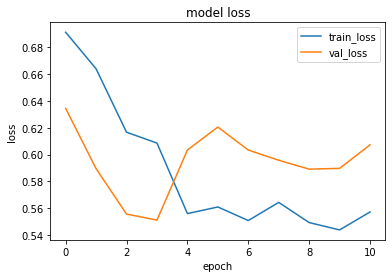

1it [00:00, 11491.24it/s]


prediction for video armflapping_1.mov is [[0.47117049]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.47732714]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.6728264]]


1it [00:00, 16980.99it/s]


prediction for video control_1.mov is [[0.21561569]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.15866375]]


1it [00:00, 9098.27it/s]


prediction for video control_3.mov is [[0.14660728]]
Epoch 1/75
3/3 [==============================] - 1s 475ms/step - loss: 0.7323 - accuracy: 0.5250 - precision_276: 0.5641 - recall_276: 0.5116 - val_loss: 0.7615 - val_accuracy: 0.3500 - val_precision_276: 0.3500 - val_recall_276: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 419ms/step - loss: 0.6676 - accuracy: 0.5500 - precision_276: 0.5443 - recall_276: 1.0000 - val_loss: 0.7060 - val_accuracy: 0.4500 - val_precision_276: 0.3889 - val_recall_276: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 467ms/step - loss: 0.6197 - accuracy: 0.6375 - precision_276: 0.6129 - recall_276: 0.8837 - val_loss: 0.6584 - val_accuracy: 0.8000 - val_precision_276: 0.6667 - val_recall_276: 0.8571
Epoch 4/75
3/3 [==============================] - 1s 441ms/step - loss: 0.6267 - accuracy: 0.6750 - precision_276: 0.7297 - recall_276: 0.6279 - val_loss: 0.6404 - val_accuracy: 0.7500 - val_precision_276: 0.6000 - val_recall_276: 0.

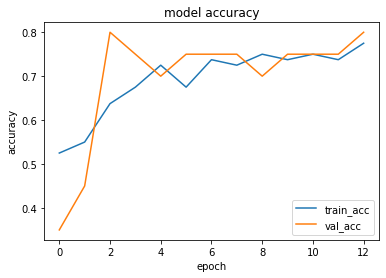

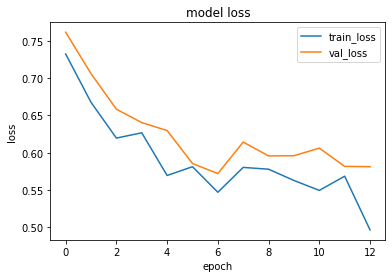

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.507239]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.6662216]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.6680622]]


1it [00:00, 16384.00it/s]


prediction for video control_1.mov is [[0.39416787]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.36223537]]


1it [00:00, 13315.25it/s]


prediction for video control_3.mov is [[0.34632593]]
Epoch 1/75
3/3 [==============================] - 1s 321ms/step - loss: 0.6529 - accuracy: 0.6125 - precision_277: 0.6333 - recall_277: 0.4872 - val_loss: 0.6352 - val_accuracy: 0.5500 - val_precision_277: 0.5714 - val_recall_277: 0.7273
Epoch 2/75
3/3 [==============================] - 1s 334ms/step - loss: 0.5888 - accuracy: 0.7375 - precision_277: 0.6731 - recall_277: 0.8974 - val_loss: 0.7759 - val_accuracy: 0.6500 - val_precision_277: 0.7500 - val_recall_277: 0.5455
Epoch 3/75
3/3 [==============================] - 1s 333ms/step - loss: 0.5918 - accuracy: 0.7625 - precision_277: 0.7381 - recall_277: 0.7949 - val_loss: 0.8047 - val_accuracy: 0.6500 - val_precision_277: 0.7500 - val_recall_277: 0.5455
Epoch 4/75
3/3 [==============================] - 1s 346ms/step - loss: 0.5992 - accuracy: 0.7750 - precision_277: 0.7442 - recall_277: 0.8205 - val_loss: 1.0690 - val_accuracy: 0.5000 - val_precision_277: 0.5556 - val_recall_277: 0.

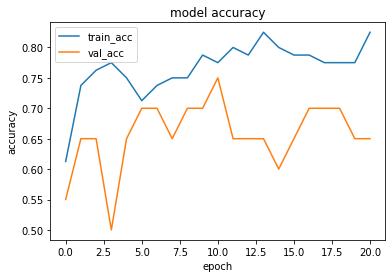

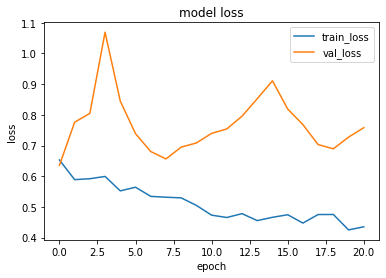

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.546608]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.7661364]]


1it [00:00, 16578.28it/s]


prediction for video armflapping_2.mov is [[0.73601913]]


1it [00:00, 19691.57it/s]


prediction for video control_1.mov is [[0.31169137]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.27123997]]


1it [00:00, 16710.37it/s]


prediction for video control_3.mov is [[0.23621109]]
Epoch 1/75
3/3 [==============================] - 1s 319ms/step - loss: 0.7236 - accuracy: 0.3875 - precision_278: 0.4211 - recall_278: 0.6000 - val_loss: 0.6033 - val_accuracy: 0.7500 - val_precision_278: 0.6667 - val_recall_278: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6279 - accuracy: 0.6375 - precision_278: 0.6170 - recall_278: 0.7250 - val_loss: 0.5214 - val_accuracy: 0.8500 - val_precision_278: 0.8182 - val_recall_278: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6061 - accuracy: 0.6625 - precision_278: 0.6327 - recall_278: 0.7750 - val_loss: 0.5608 - val_accuracy: 0.6500 - val_precision_278: 0.6000 - val_recall_278: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 355ms/step - loss: 0.5865 - accuracy: 0.7000 - precision_278: 0.6600 - recall_278: 0.8250 - val_loss: 0.5226 - val_accuracy: 0.7000 - val_precision_278: 0.7500 - val_recall_278: 0.

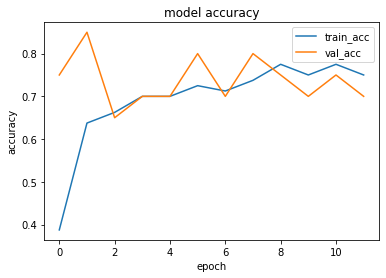

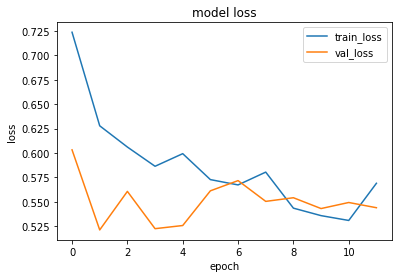

1it [00:00, 13662.23it/s]


prediction for video armflapping_1.mov is [[0.5051545]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.5177862]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.52308637]]


1it [00:00, 11491.24it/s]


prediction for video control_1.mov is [[0.48379877]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.479449]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.47253582]]


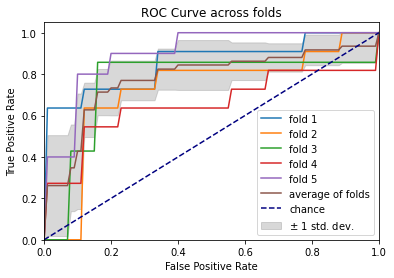

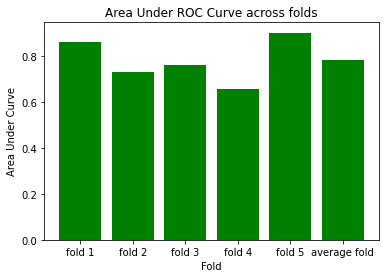

In [146]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 359ms/step - loss: 0.7026 - accuracy: 0.5750 - precision_214: 0.5400 - recall_214: 0.7105 - val_loss: 0.6729 - val_accuracy: 0.5500 - val_precision_214: 0.6364 - val_recall_214: 0.5833
Epoch 2/75
3/3 [==============================] - 1s 338ms/step - loss: 0.6457 - accuracy: 0.7000 - precision_214: 0.6842 - recall_214: 0.6842 - val_loss: 0.8804 - val_accuracy: 0.4500 - val_precision_214: 0.5714 - val_recall_214: 0.3333
Epoch 3/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6047 - accuracy: 0.6750 - precision_214: 0.7000 - recall_214: 0.5526 - val_loss: 0.7130 - val_accuracy: 0.5500 - val_precision_214: 0.6154 - val_recall_214: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 322ms/step - loss: 0.5902 - accuracy: 0.7250 - precision_214: 0.6818 - recall_214: 0.7895 - val_loss: 0.7694 - val_accuracy: 0.6000 - val_precision_214: 0.6429 - val_recall_214: 0.7500
Epoch 5/75
3/3 [==============================] 

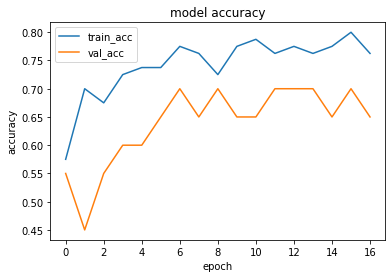

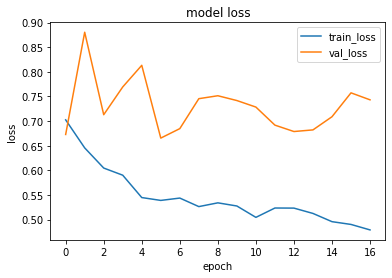

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.55353624]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.65259296]]


1it [00:00, 15768.06it/s]


prediction for video armflapping_2.mov is [[0.73344046]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.268466]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.22807837]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.22611484]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.7270 - accuracy: 0.5500 - precision_215: 0.5231 - recall_215: 0.8718 - val_loss: 0.6520 - val_accuracy: 0.6500 - val_precision_215: 0.8333 - val_recall_215: 0.4545
Epoch 2/75
3/3 [==============================] - 1s 360ms/step - loss: 0.6525 - accuracy: 0.6875 - precision_215: 0.7333 - recall_215: 0.5641 - val_loss: 0.6216 - val_accuracy: 0.7000 - val_precision_215: 0.7273 - val_recall_215: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6146 - accuracy: 0.7500 - precision_215: 0.7317 - recall_215: 0.7692 - val_loss: 0.5985 - val_accuracy: 0.7000 - val_precision_215: 0.6667 - val_recall_215: 0.9091
Epoch 4/75
3/3 [==============================] - 1s 308ms/step - loss: 0.5832 - accuracy: 0.7500 - precision_215: 0.7209 - recall_215: 0.7949 - val_loss: 0.5791 - val_accuracy: 0.7500 - val_precision_215: 0.8000 - val_recall_215: 0.

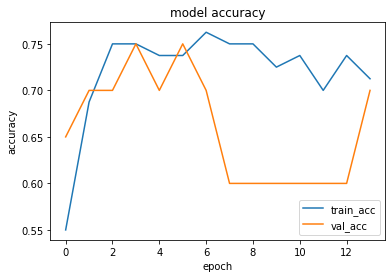

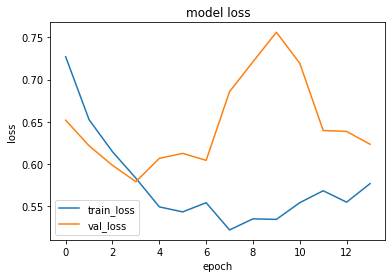

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.3838553]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.53482187]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.5613056]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.27610037]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.2501958]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.23635969]]
Epoch 1/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6995 - accuracy: 0.5500 - precision_216: 0.6071 - recall_216: 0.4048 - val_loss: 0.6877 - val_accuracy: 0.4500 - val_precision_216: 0.4211 - val_recall_216: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 324ms/step - loss: 0.6425 - accuracy: 0.6500 - precision_216: 0.6167 - recall_216: 0.8810 - val_loss: 0.6987 - val_accuracy: 0.4000 - val_precision_216: 0.3889 - val_recall_216: 0.8750
Epoch 3/75
3/3 [==============================] - 1s 316ms/step - loss: 0.6099 - accuracy: 0.6000 - precision_216: 0.5714 - recall_216: 0.9524 - val_loss: 0.7263 - val_accuracy: 0.6500 - val_precision_216: 0.5385 - val_recall_216: 0.8750
Epoch 4/75
3/3 [==============================] - 1s 301ms/step - loss: 0.5720 - accuracy: 0.7125 - precision_216: 0.7111 - recall_216: 0.7619 - val_loss: 0.6502 - val_accuracy: 0.7500 - val_precision_216: 0.6667 - val_recall_216: 0.

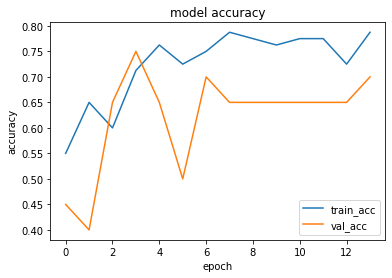

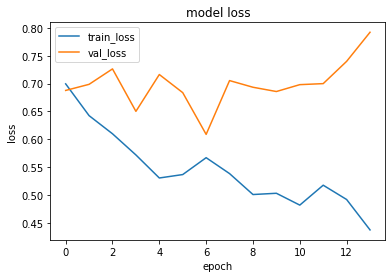

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.50838685]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.79122937]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.72728807]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.44068053]]


1it [00:00, 13888.42it/s]


prediction for video control_2.mov is [[0.27613074]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.44131106]]
Epoch 1/75
3/3 [==============================] - 1s 361ms/step - loss: 0.6797 - accuracy: 0.5375 - precision_217: 0.5556 - recall_217: 0.5952 - val_loss: 0.6690 - val_accuracy: 0.4500 - val_precision_217: 0.4118 - val_recall_217: 0.8750
Epoch 2/75
3/3 [==============================] - 1s 288ms/step - loss: 0.6744 - accuracy: 0.5750 - precision_217: 0.5541 - recall_217: 0.9762 - val_loss: 0.6738 - val_accuracy: 0.6500 - val_precision_217: 0.6667 - val_recall_217: 0.2500
Epoch 3/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6166 - accuracy: 0.7500 - precision_217: 0.7895 - recall_217: 0.7143 - val_loss: 0.6416 - val_accuracy: 0.7500 - val_precision_217: 0.7143 - val_recall_217: 0.6250
Epoch 4/75
3/3 [==============================] - 1s 288ms/step - loss: 0.6094 - accuracy: 0.7000 - precision_217: 0.6800 - recall_217: 0.8095 - val_loss: 0.6197 - val_accuracy: 0.7000 - val_precision_217: 0.6250 - val_recall_217: 0.

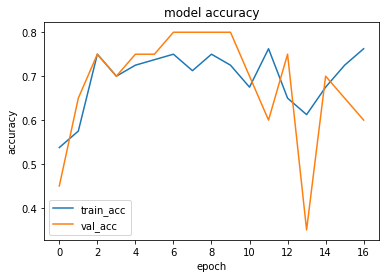

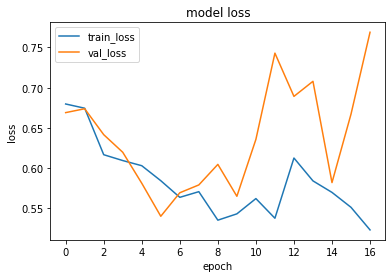

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.39438203]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.46497038]]


1it [00:00, 16320.25it/s]


prediction for video armflapping_2.mov is [[0.67925423]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.35914916]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.2897877]]


1it [00:00, 17772.47it/s]


prediction for video control_3.mov is [[0.32337737]]
Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.6905 - accuracy: 0.5375 - precision_218: 0.5172 - recall_218: 0.7692 - val_loss: 0.6524 - val_accuracy: 0.6500 - val_precision_218: 0.6250 - val_recall_218: 0.9091
Epoch 2/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6949 - accuracy: 0.6375 - precision_218: 0.5962 - recall_218: 0.7949 - val_loss: 0.6335 - val_accuracy: 0.7000 - val_precision_218: 0.7778 - val_recall_218: 0.6364
Epoch 3/75
3/3 [==============================] - 1s 361ms/step - loss: 0.6627 - accuracy: 0.6125 - precision_218: 0.7000 - recall_218: 0.3590 - val_loss: 0.6057 - val_accuracy: 0.8000 - val_precision_218: 1.0000 - val_recall_218: 0.6364
Epoch 4/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6095 - accuracy: 0.6875 - precision_218: 0.7500 - recall_218: 0.5385 - val_loss: 0.5574 - val_accuracy: 0.9000 - val_precision_218: 0.9091 - val_recall_218: 0.

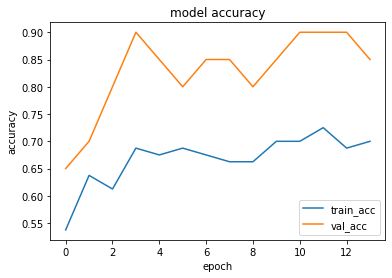

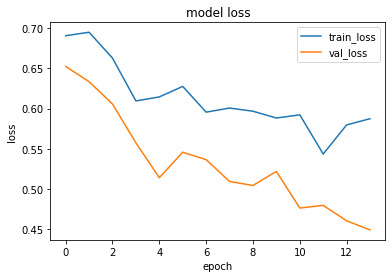

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.15671301]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_3.mov is [[0.56558025]]


1it [00:00, 15087.42it/s]


prediction for video armflapping_2.mov is [[0.3701898]]


1it [00:00, 22192.08it/s]


prediction for video control_1.mov is [[0.14309064]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.14081734]]


1it [00:00, 17476.27it/s]

prediction for video control_3.mov is [[0.1414338]]


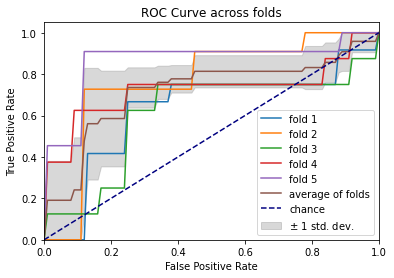

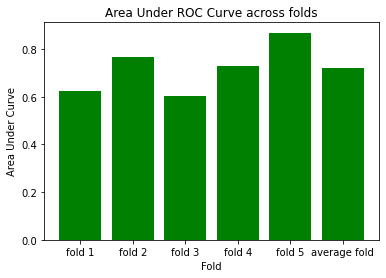

In [121]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 321ms/step - loss: 0.6456 - accuracy: 0.5500 - precision_220: 0.5147 - recall_220: 0.9211 - val_loss: 0.7630 - val_accuracy: 0.4000 - val_precision_220: 0.0000e+00 - val_recall_220: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6753 - accuracy: 0.6500 - precision_220: 0.6786 - recall_220: 0.5000 - val_loss: 0.6953 - val_accuracy: 0.5500 - val_precision_220: 0.6154 - val_recall_220: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 305ms/step - loss: 0.5929 - accuracy: 0.7500 - precision_220: 0.7143 - recall_220: 0.7895 - val_loss: 0.7061 - val_accuracy: 0.5500 - val_precision_220: 0.6000 - val_recall_220: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 305ms/step - loss: 0.5439 - accuracy: 0.7375 - precision_220: 0.6977 - recall_220: 0.7895 - val_loss: 0.7843 - val_accuracy: 0.6500 - val_precision_220: 0.6923 - val_recall_220: 0.7500
Epoch 5/75
3/3 [========================

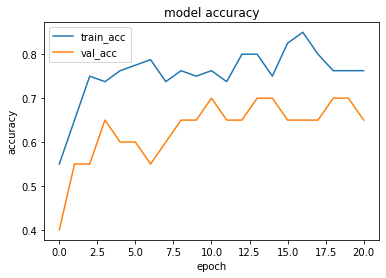

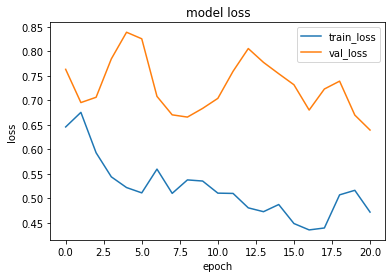

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.39927763]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.72754675]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.72810715]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.15996099]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.13926345]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.13709694]]
Epoch 1/75
3/3 [==============================] - 1s 382ms/step - loss: 0.7365 - accuracy: 0.4875 - precision_221: 0.4839 - recall_221: 0.7692 - val_loss: 0.6511 - val_accuracy: 0.7000 - val_precision_221: 0.7778 - val_recall_221: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6827 - accuracy: 0.6250 - precision_221: 0.6216 - recall_221: 0.5897 - val_loss: 0.6321 - val_accuracy: 0.7500 - val_precision_221: 0.7500 - val_recall_221: 0.8182
Epoch 3/75
3/3 [==============================] - 1s 304ms/step - loss: 0.6473 - accuracy: 0.6750 - precision_221: 0.7097 - recall_221: 0.5641 - val_loss: 0.6099 - val_accuracy: 0.8000 - val_precision_221: 0.8889 - val_recall_221: 0.7273
Epoch 4/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6196 - accuracy: 0.7125 - precision_221: 0.7222 - recall_221: 0.6667 - val_loss: 0.5647 - val_accuracy: 0.7000 - val_precision_221: 0.6667 - val_recall_221: 0.

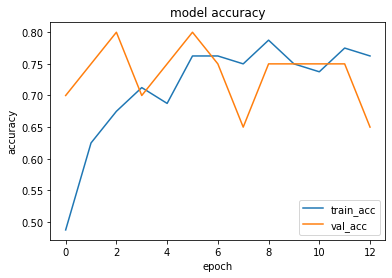

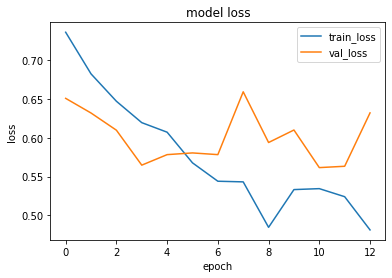

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.45186362]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.48533267]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5110193]]


1it [00:00, 2816.86it/s]


prediction for video control_1.mov is [[0.41846064]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.40251878]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.3938461]]
Epoch 1/75
3/3 [==============================] - 1s 330ms/step - loss: 0.6924 - accuracy: 0.4875 - precision_222: 0.5135 - recall_222: 0.4524 - val_loss: 0.6703 - val_accuracy: 0.4000 - val_precision_222: 0.3889 - val_recall_222: 0.8750
Epoch 2/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6217 - accuracy: 0.6375 - precision_222: 0.6182 - recall_222: 0.8095 - val_loss: 0.6657 - val_accuracy: 0.6500 - val_precision_222: 0.5385 - val_recall_222: 0.8750
Epoch 3/75
3/3 [==============================] - 1s 308ms/step - loss: 0.5966 - accuracy: 0.7250 - precision_222: 0.7083 - recall_222: 0.8095 - val_loss: 0.6371 - val_accuracy: 0.7000 - val_precision_222: 0.6000 - val_recall_222: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 351ms/step - loss: 0.5822 - accuracy: 0.7250 - precision_222: 0.7778 - recall_222: 0.6667 - val_loss: 0.6607 - val_accuracy: 0.7000 - val_precision_222: 0.6000 - val_recall_222: 0.7

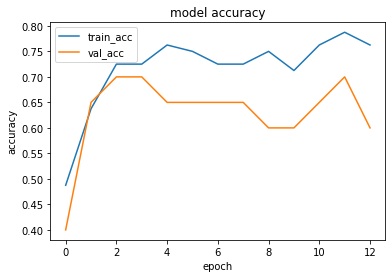

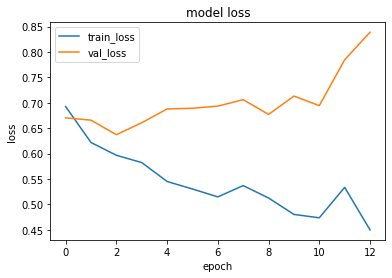

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.6892264]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.8821663]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.771132]]


1it [00:00, 16448.25it/s]


prediction for video control_1.mov is [[0.53916043]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.6091018]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.44538754]]
Epoch 1/75
3/3 [==============================] - 1s 307ms/step - loss: 0.7622 - accuracy: 0.4875 - precision_223: 0.5185 - recall_223: 0.3333 - val_loss: 0.6910 - val_accuracy: 0.4000 - val_precision_223: 0.3889 - val_recall_223: 0.8750
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6793 - accuracy: 0.5625 - precision_223: 0.5479 - recall_223: 0.9524 - val_loss: 0.6845 - val_accuracy: 0.4500 - val_precision_223: 0.4211 - val_recall_223: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6763 - accuracy: 0.5750 - precision_223: 0.5526 - recall_223: 1.0000 - val_loss: 0.6659 - val_accuracy: 0.4000 - val_precision_223: 0.3889 - val_recall_223: 0.8750
Epoch 4/75
3/3 [==============================] - 1s 350ms/step - loss: 0.6545 - accuracy: 0.6375 - precision_223: 0.6102 - recall_223: 0.8571 - val_loss: 0.6519 - val_accuracy: 0.7500 - val_precision_223: 0.7143 - val_recall_223: 0.

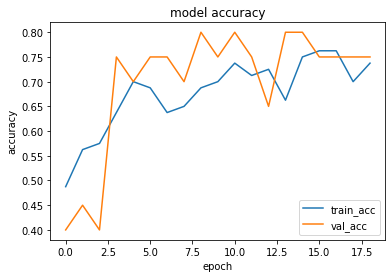

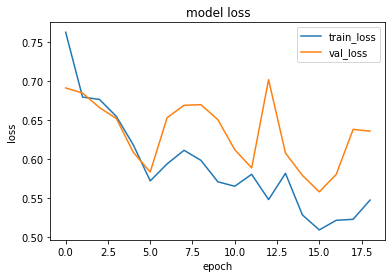

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.5037943]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.6466917]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_2.mov is [[0.73014253]]


1it [00:00, 13706.88it/s]


prediction for video control_1.mov is [[0.33156458]]


1it [00:00, 12985.46it/s]


prediction for video control_2.mov is [[0.27988037]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.28418475]]
Epoch 1/75
3/3 [==============================] - 1s 297ms/step - loss: 0.7205 - accuracy: 0.4500 - precision_224: 0.4638 - recall_224: 0.8205 - val_loss: 0.6294 - val_accuracy: 0.8000 - val_precision_224: 1.0000 - val_recall_224: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 343ms/step - loss: 0.6671 - accuracy: 0.6125 - precision_224: 0.7500 - recall_224: 0.3077 - val_loss: 0.6072 - val_accuracy: 0.7500 - val_precision_224: 1.0000 - val_recall_224: 0.5455
Epoch 3/75
3/3 [==============================] - 1s 289ms/step - loss: 0.6791 - accuracy: 0.6000 - precision_224: 0.7059 - recall_224: 0.3077 - val_loss: 0.5243 - val_accuracy: 0.8500 - val_precision_224: 0.8333 - val_recall_224: 0.9091
Epoch 4/75
3/3 [==============================] - 1s 287ms/step - loss: 0.6166 - accuracy: 0.6750 - precision_224: 0.6226 - recall_224: 0.8462 - val_loss: 0.5460 - val_accuracy: 0.6500 - val_precision_224: 0.6250 - val_recall_224: 0.

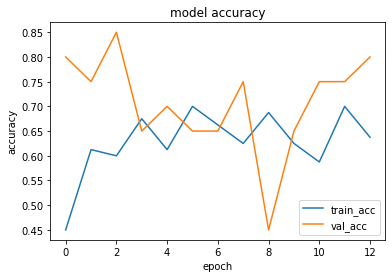

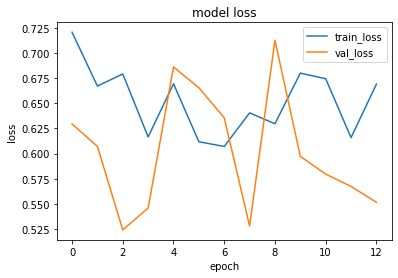

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.517227]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.59673196]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.5945173]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.48207042]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.47057745]]


1it [00:00, 15363.75it/s]

prediction for video control_3.mov is [[0.45839357]]


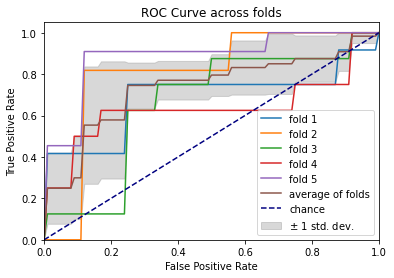

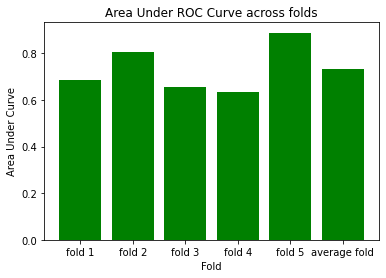

In [122]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 336ms/step - loss: 0.7123 - accuracy: 0.5000 - precision_226: 0.4833 - recall_226: 0.7632 - val_loss: 0.6705 - val_accuracy: 0.6500 - val_precision_226: 0.7273 - val_recall_226: 0.6667
Epoch 2/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6531 - accuracy: 0.6625 - precision_226: 0.6774 - recall_226: 0.5526 - val_loss: 0.7210 - val_accuracy: 0.6000 - val_precision_226: 0.6429 - val_recall_226: 0.7500
Epoch 3/75
3/3 [==============================] - 1s 309ms/step - loss: 0.5723 - accuracy: 0.7500 - precision_226: 0.7143 - recall_226: 0.7895 - val_loss: 0.8376 - val_accuracy: 0.5000 - val_precision_226: 0.6250 - val_recall_226: 0.4167
Epoch 4/75
3/3 [==============================] - 1s 304ms/step - loss: 0.5849 - accuracy: 0.7125 - precision_226: 0.7419 - recall_226: 0.6053 - val_loss: 0.7192 - val_accuracy: 0.5500 - val_precision_226: 0.6154 - val_recall_226: 0.6667
Epoch 5/75
3/3 [==============================] 

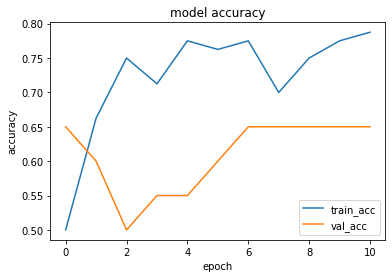

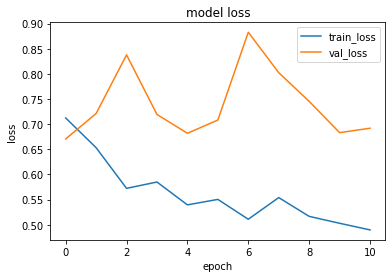

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.50513667]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.5263019]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.5368952]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.49118114]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.4828016]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.4831982]]
Epoch 1/75
3/3 [==============================] - 1s 298ms/step - loss: 0.7000 - accuracy: 0.6250 - precision_227: 0.6000 - recall_227: 0.6923 - val_loss: 0.6555 - val_accuracy: 0.7000 - val_precision_227: 0.8571 - val_recall_227: 0.5455
Epoch 2/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6583 - accuracy: 0.6250 - precision_227: 0.6800 - recall_227: 0.4359 - val_loss: 0.5857 - val_accuracy: 0.7500 - val_precision_227: 0.6875 - val_recall_227: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 360ms/step - loss: 0.6481 - accuracy: 0.6625 - precision_227: 0.6111 - recall_227: 0.8462 - val_loss: 0.5642 - val_accuracy: 0.7500 - val_precision_227: 0.7500 - val_recall_227: 0.8182
Epoch 4/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6217 - accuracy: 0.7250 - precision_227: 0.7179 - recall_227: 0.7179 - val_loss: 0.5915 - val_accuracy: 0.7500 - val_precision_227: 0.8750 - val_recall_227: 0.6

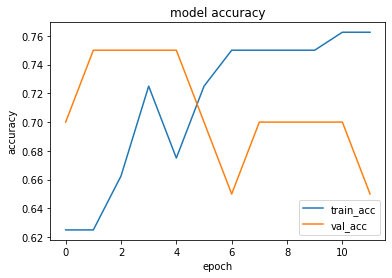

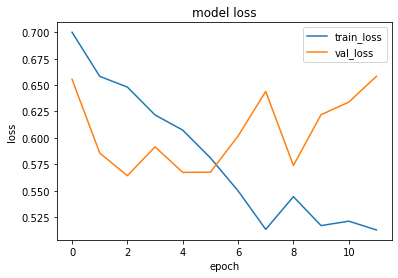

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.58570445]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.67485464]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.7219775]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.46981663]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.43510985]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.41288316]]
Epoch 1/75
3/3 [==============================] - 1s 350ms/step - loss: 0.7011 - accuracy: 0.5500 - precision_228: 0.5652 - recall_228: 0.6190 - val_loss: 0.6894 - val_accuracy: 0.4500 - val_precision_228: 0.4211 - val_recall_228: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6777 - accuracy: 0.6625 - precision_228: 0.6230 - recall_228: 0.9048 - val_loss: 0.6746 - val_accuracy: 0.6000 - val_precision_228: 0.5000 - val_recall_228: 0.2500
Epoch 3/75
3/3 [==============================] - 1s 494ms/step - loss: 0.6194 - accuracy: 0.7375 - precision_228: 0.7838 - recall_228: 0.6905 - val_loss: 0.6975 - val_accuracy: 0.6000 - val_precision_228: 0.5000 - val_recall_228: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 446ms/step - loss: 0.5445 - accuracy: 0.7625 - precision_228: 0.7674 - recall_228: 0.7857 - val_loss: 0.6274 - val_accuracy: 0.7500 - val_precision_228: 0.6154 - val_recall_228: 1.

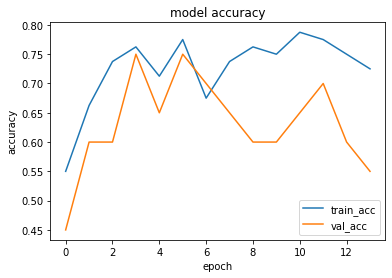

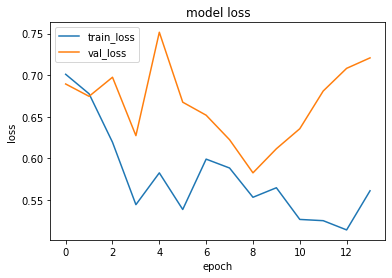

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.37402236]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.4337233]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.47466728]]


1it [00:00, 12865.96it/s]


prediction for video control_1.mov is [[0.3325199]]


1it [00:00, 20867.18it/s]


prediction for video control_2.mov is [[0.36033684]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.3606668]]
Epoch 1/75
3/3 [==============================] - 1s 381ms/step - loss: 0.8151 - accuracy: 0.5250 - precision_229: 0.5263 - recall_229: 0.9524 - val_loss: 0.6754 - val_accuracy: 0.7500 - val_precision_229: 1.0000 - val_recall_229: 0.3750
Epoch 2/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6746 - accuracy: 0.6000 - precision_229: 0.7500 - recall_229: 0.3571 - val_loss: 0.6823 - val_accuracy: 0.7000 - val_precision_229: 1.0000 - val_recall_229: 0.2500
Epoch 3/75
3/3 [==============================] - 1s 307ms/step - loss: 0.6614 - accuracy: 0.6750 - precision_229: 0.7105 - recall_229: 0.6429 - val_loss: 0.6700 - val_accuracy: 0.7000 - val_precision_229: 0.6250 - val_recall_229: 0.6250
Epoch 4/75
3/3 [==============================] - 1s 382ms/step - loss: 0.6401 - accuracy: 0.6375 - precision_229: 0.6182 - recall_229: 0.8095 - val_loss: 0.6544 - val_accuracy: 0.7000 - val_precision_229: 0.6250 - val_recall_229: 0.6

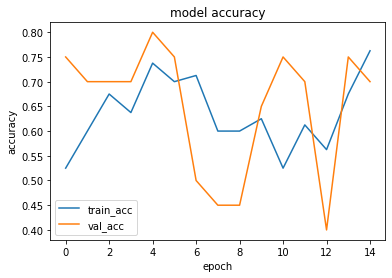

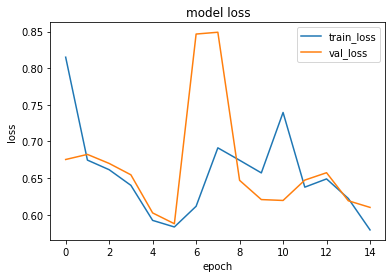

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.48866194]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.56126076]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.6698548]]


1it [00:00, 10979.85it/s]


prediction for video control_1.mov is [[0.44049993]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.41716343]]


1it [00:00, 14027.77it/s]


prediction for video control_3.mov is [[0.3992255]]
Epoch 1/75
3/3 [==============================] - 1s 409ms/step - loss: 0.6967 - accuracy: 0.5250 - precision_230: 0.5094 - recall_230: 0.6923 - val_loss: 0.6080 - val_accuracy: 0.7500 - val_precision_230: 1.0000 - val_recall_230: 0.5455
Epoch 2/75
3/3 [==============================] - 1s 402ms/step - loss: 0.6719 - accuracy: 0.5625 - precision_230: 0.6250 - recall_230: 0.2564 - val_loss: 0.5919 - val_accuracy: 0.8000 - val_precision_230: 0.8889 - val_recall_230: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 426ms/step - loss: 0.6281 - accuracy: 0.7250 - precision_230: 0.7576 - recall_230: 0.6410 - val_loss: 0.5277 - val_accuracy: 0.8000 - val_precision_230: 0.7692 - val_recall_230: 0.9091
Epoch 4/75
3/3 [==============================] - 1s 391ms/step - loss: 0.6263 - accuracy: 0.6750 - precision_230: 0.6226 - recall_230: 0.8462 - val_loss: 0.4794 - val_accuracy: 0.8500 - val_precision_230: 0.9000 - val_recall_230: 0.8

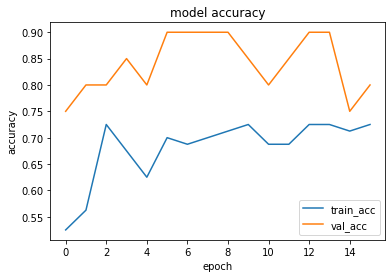

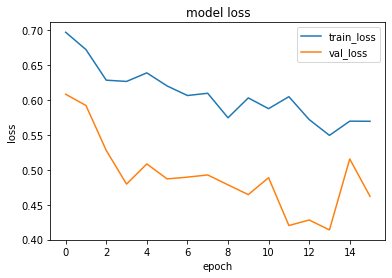

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.48371905]]


1it [00:00, 13934.56it/s]


prediction for video armflapping_3.mov is [[0.5175264]]


1it [00:00, 13842.59it/s]


prediction for video armflapping_2.mov is [[0.5403562]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.42519355]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.39676693]]


1it [00:00, 13486.51it/s]


prediction for video control_3.mov is [[0.38547084]]


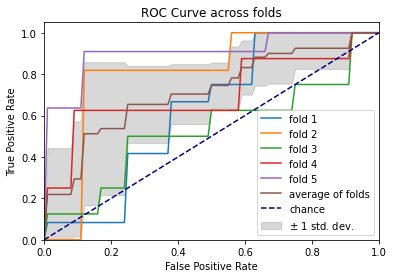

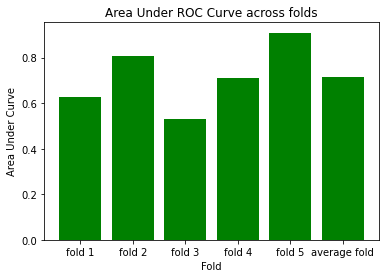

In [123]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 352ms/step - loss: 0.7302 - accuracy: 0.5750 - precision_232: 0.5370 - recall_232: 0.7632 - val_loss: 0.6886 - val_accuracy: 0.5500 - val_precision_232: 0.8000 - val_recall_232: 0.3333
Epoch 2/75
3/3 [==============================] - 1s 343ms/step - loss: 0.6589 - accuracy: 0.6625 - precision_232: 0.8235 - recall_232: 0.3684 - val_loss: 0.6995 - val_accuracy: 0.5500 - val_precision_232: 0.6364 - val_recall_232: 0.5833
Epoch 3/75
3/3 [==============================] - 1s 354ms/step - loss: 0.5991 - accuracy: 0.7250 - precision_232: 0.7222 - recall_232: 0.6842 - val_loss: 0.7708 - val_accuracy: 0.5500 - val_precision_232: 0.5789 - val_recall_232: 0.9167
Epoch 4/75
3/3 [==============================] - 1s 437ms/step - loss: 0.7212 - accuracy: 0.5625 - precision_232: 0.5211 - recall_232: 0.9737 - val_loss: 0.6912 - val_accuracy: 0.6000 - val_precision_232: 0.6000 - val_recall_232: 1.0000
Epoch 5/75
3/3 [==============================] 

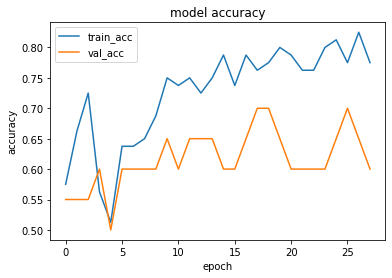

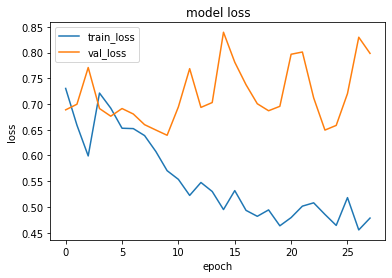

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.59049433]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.6210034]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.7242214]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.20040035]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.14697352]]


1it [00:00, 9731.56it/s]


prediction for video control_3.mov is [[0.14347953]]
Epoch 1/75
3/3 [==============================] - 1s 381ms/step - loss: 0.7426 - accuracy: 0.4500 - precision_233: 0.4510 - recall_233: 0.5897 - val_loss: 0.6309 - val_accuracy: 0.7000 - val_precision_233: 0.6923 - val_recall_233: 0.8182
Epoch 2/75
3/3 [==============================] - 1s 394ms/step - loss: 0.6731 - accuracy: 0.6375 - precision_233: 0.6667 - recall_233: 0.5128 - val_loss: 0.6443 - val_accuracy: 0.5500 - val_precision_233: 0.7500 - val_recall_233: 0.2727
Epoch 3/75
3/3 [==============================] - 1s 445ms/step - loss: 0.6563 - accuracy: 0.6500 - precision_233: 0.7200 - recall_233: 0.4615 - val_loss: 0.6163 - val_accuracy: 0.8000 - val_precision_233: 0.8889 - val_recall_233: 0.7273
Epoch 4/75
3/3 [==============================] - 1s 383ms/step - loss: 0.6396 - accuracy: 0.7125 - precision_233: 0.6905 - recall_233: 0.7436 - val_loss: 0.6018 - val_accuracy: 0.7500 - val_precision_233: 0.8000 - val_recall_233: 0.

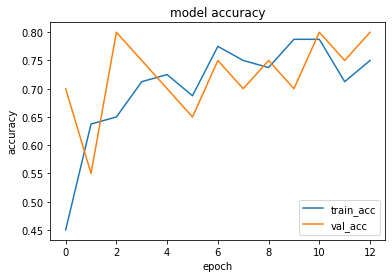

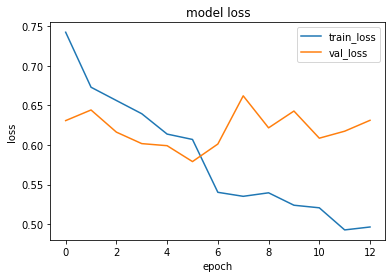

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.48957396]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.51766104]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.51706684]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.47510636]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.4688543]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.46765947]]
Epoch 1/75
3/3 [==============================] - 1s 298ms/step - loss: 0.6767 - accuracy: 0.4375 - precision_234: 0.4727 - recall_234: 0.6190 - val_loss: 0.6693 - val_accuracy: 0.5500 - val_precision_234: 0.4667 - val_recall_234: 0.8750
Epoch 2/75
3/3 [==============================] - 1s 299ms/step - loss: 0.5973 - accuracy: 0.6250 - precision_234: 0.6111 - recall_234: 0.7857 - val_loss: 0.6815 - val_accuracy: 0.6000 - val_precision_234: 0.5000 - val_recall_234: 0.2500
Epoch 3/75
3/3 [==============================] - 1s 361ms/step - loss: 0.5726 - accuracy: 0.7375 - precision_234: 0.8387 - recall_234: 0.6190 - val_loss: 0.6915 - val_accuracy: 0.7000 - val_precision_234: 0.6000 - val_recall_234: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 329ms/step - loss: 0.5334 - accuracy: 0.7500 - precision_234: 0.7750 - recall_234: 0.7381 - val_loss: 0.7358 - val_accuracy: 0.6500 - val_precision_234: 0.5455 - val_recall_234: 0.

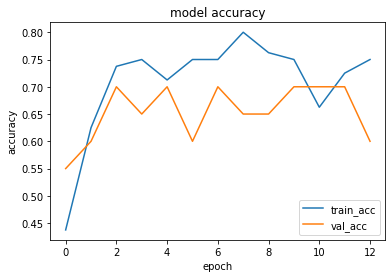

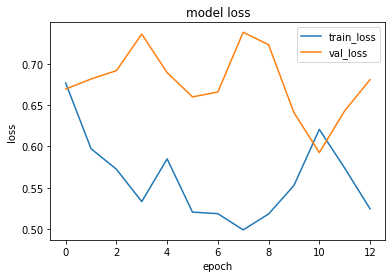

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.4749526]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.559895]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.589484]]


1it [00:00, 17924.38it/s]


prediction for video control_1.mov is [[0.42862514]]


1it [00:00, 16912.52it/s]


prediction for video control_2.mov is [[0.41428927]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.42332372]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.7601 - accuracy: 0.5125 - precision_235: 0.5231 - recall_235: 0.8095 - val_loss: 0.6778 - val_accuracy: 0.7500 - val_precision_235: 0.7143 - val_recall_235: 0.6250
Epoch 2/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6571 - accuracy: 0.6875 - precision_235: 0.6809 - recall_235: 0.7619 - val_loss: 0.6728 - val_accuracy: 0.6000 - val_precision_235: 0.5000 - val_recall_235: 0.8750
Epoch 3/75
3/3 [==============================] - 1s 345ms/step - loss: 0.6313 - accuracy: 0.6000 - precision_235: 0.5758 - recall_235: 0.9048 - val_loss: 0.6498 - val_accuracy: 0.6000 - val_precision_235: 0.5000 - val_recall_235: 0.6250
Epoch 4/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6030 - accuracy: 0.6750 - precision_235: 0.6667 - recall_235: 0.7619 - val_loss: 0.6068 - val_accuracy: 0.7500 - val_precision_235: 0.7143 - val_recall_235: 0.

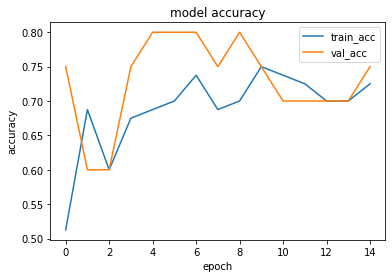

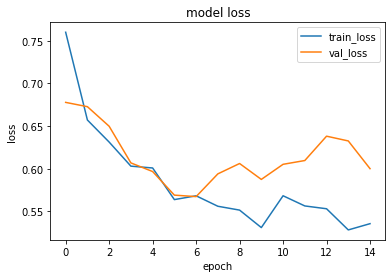

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.60818183]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.6815538]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.6836275]]


1it [00:00, 18236.10it/s]


prediction for video control_1.mov is [[0.34377807]]


1it [00:00, 15827.56it/s]


prediction for video control_2.mov is [[0.33528876]]


1it [00:00, 18477.11it/s]


prediction for video control_3.mov is [[0.3336482]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.7159 - accuracy: 0.4750 - precision_236: 0.4717 - recall_236: 0.6410 - val_loss: 0.6469 - val_accuracy: 0.6000 - val_precision_236: 1.0000 - val_recall_236: 0.2727
Epoch 2/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6725 - accuracy: 0.6125 - precision_236: 0.6538 - recall_236: 0.4359 - val_loss: 0.6219 - val_accuracy: 0.8500 - val_precision_236: 1.0000 - val_recall_236: 0.7273
Epoch 3/75
3/3 [==============================] - 1s 353ms/step - loss: 0.6619 - accuracy: 0.6875 - precision_236: 0.7059 - recall_236: 0.6154 - val_loss: 0.6090 - val_accuracy: 0.8000 - val_precision_236: 0.7692 - val_recall_236: 0.9091
Epoch 4/75
3/3 [==============================] - 1s 293ms/step - loss: 0.6547 - accuracy: 0.6750 - precision_236: 0.6757 - recall_236: 0.6410 - val_loss: 0.5910 - val_accuracy: 0.7000 - val_precision_236: 0.6667 - val_recall_236: 0.9

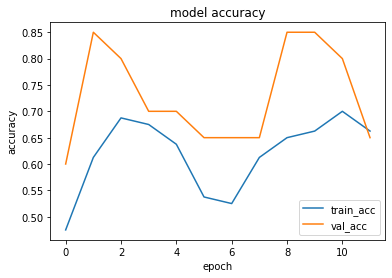

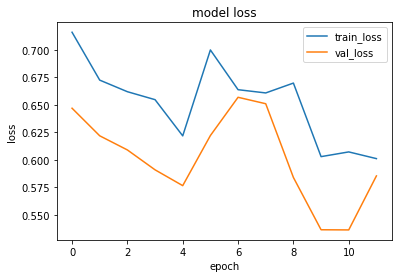

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.4949721]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.5027815]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.51261836]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.48730418]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.48686492]]


1it [00:00, 16912.52it/s]

prediction for video control_3.mov is [[0.48686433]]


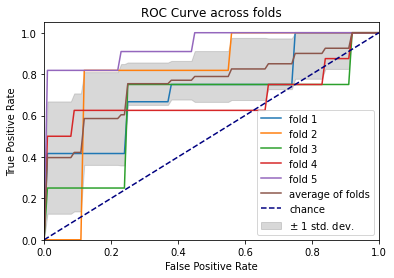

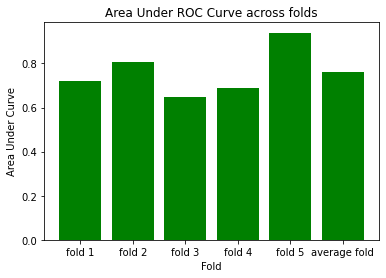

In [124]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 319ms/step - loss: 0.6911 - accuracy: 0.5000 - precision_238: 0.4815 - recall_238: 0.6842 - val_loss: 0.6513 - val_accuracy: 0.6500 - val_precision_238: 0.6923 - val_recall_238: 0.7500
Epoch 2/75
3/3 [==============================] - 1s 308ms/step - loss: 0.7726 - accuracy: 0.6125 - precision_238: 0.5593 - recall_238: 0.8684 - val_loss: 0.6801 - val_accuracy: 0.5500 - val_precision_238: 0.6154 - val_recall_238: 0.6667
Epoch 3/75
3/3 [==============================] - 1s 318ms/step - loss: 0.6255 - accuracy: 0.7375 - precision_238: 0.7073 - recall_238: 0.7632 - val_loss: 0.6763 - val_accuracy: 0.6500 - val_precision_238: 0.7273 - val_recall_238: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 369ms/step - loss: 0.6089 - accuracy: 0.7125 - precision_238: 0.7419 - recall_238: 0.6053 - val_loss: 0.6756 - val_accuracy: 0.6000 - val_precision_238: 0.6667 - val_recall_238: 0.6667
Epoch 5/75
3/3 [==============================] 

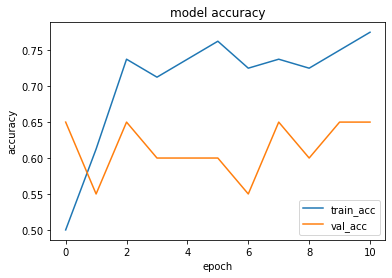

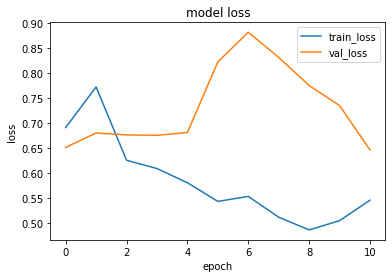

1it [00:00, 12985.46it/s]


prediction for video armflapping_1.mov is [[0.53313136]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.54854393]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.6147596]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.49443293]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.4821481]]


1it [00:00, 13662.23it/s]


prediction for video control_3.mov is [[0.4772889]]
Epoch 1/75
3/3 [==============================] - 1s 303ms/step - loss: 0.6931 - accuracy: 0.6250 - precision_239: 0.6000 - recall_239: 0.6923 - val_loss: 0.6666 - val_accuracy: 0.6000 - val_precision_239: 0.8000 - val_recall_239: 0.3636
Epoch 2/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6497 - accuracy: 0.6500 - precision_239: 0.6897 - recall_239: 0.5128 - val_loss: 0.5891 - val_accuracy: 0.6000 - val_precision_239: 0.5882 - val_recall_239: 0.9091
Epoch 3/75
3/3 [==============================] - 1s 321ms/step - loss: 0.6664 - accuracy: 0.6250 - precision_239: 0.5738 - recall_239: 0.8974 - val_loss: 0.5679 - val_accuracy: 0.7500 - val_precision_239: 0.7500 - val_recall_239: 0.8182
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6647 - accuracy: 0.6250 - precision_239: 0.6098 - recall_239: 0.6410 - val_loss: 0.6311 - val_accuracy: 0.6000 - val_precision_239: 0.8000 - val_recall_239: 0.3

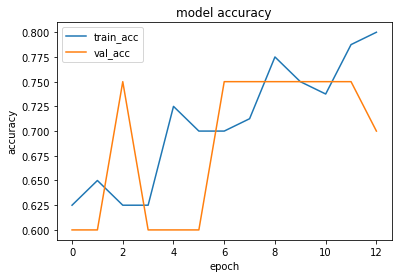

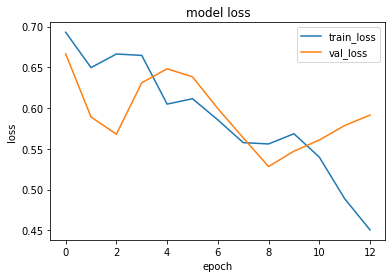

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.48111734]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.50409126]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.54731375]]


1it [00:00, 19599.55it/s]


prediction for video control_1.mov is [[0.4260954]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.40489098]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.3935165]]
Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.7210 - accuracy: 0.5125 - precision_240: 0.5600 - recall_240: 0.3333 - val_loss: 0.7077 - val_accuracy: 0.4000 - val_precision_240: 0.4000 - val_recall_240: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 314ms/step - loss: 0.7063 - accuracy: 0.5250 - precision_240: 0.5250 - recall_240: 1.0000 - val_loss: 0.6755 - val_accuracy: 0.4500 - val_precision_240: 0.4211 - val_recall_240: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 328ms/step - loss: 0.6154 - accuracy: 0.7500 - precision_240: 0.7115 - recall_240: 0.8810 - val_loss: 0.6830 - val_accuracy: 0.6000 - val_precision_240: 0.5000 - val_recall_240: 0.1250
Epoch 4/75
3/3 [==============================] - 1s 356ms/step - loss: 0.6349 - accuracy: 0.7000 - precision_240: 0.9091 - recall_240: 0.4762 - val_loss: 0.6607 - val_accuracy: 0.7000 - val_precision_240: 0.6250 - val_recall_240: 0.6

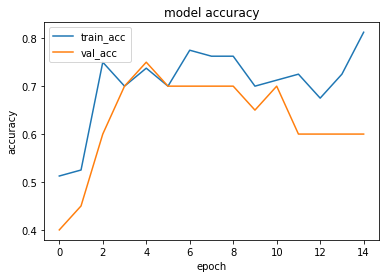

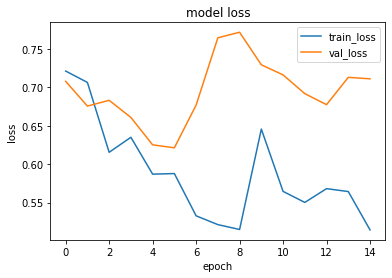

1it [00:00, 14768.68it/s]


prediction for video armflapping_1.mov is [[0.47096348]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.7011204]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_2.mov is [[0.6304742]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.49357218]]


1it [00:00, 17549.39it/s]


prediction for video control_2.mov is [[0.45633006]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.4496491]]
Epoch 1/75
3/3 [==============================] - 1s 317ms/step - loss: 0.7510 - accuracy: 0.4750 - precision_241: 0.5000 - recall_241: 0.1190 - val_loss: 0.6603 - val_accuracy: 0.4500 - val_precision_241: 0.4211 - val_recall_241: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 329ms/step - loss: 0.6839 - accuracy: 0.5625 - precision_241: 0.5455 - recall_241: 1.0000 - val_loss: 0.6645 - val_accuracy: 0.4500 - val_precision_241: 0.4118 - val_recall_241: 0.8750
Epoch 3/75
3/3 [==============================] - 1s 295ms/step - loss: 0.6393 - accuracy: 0.5875 - precision_241: 0.5672 - recall_241: 0.9048 - val_loss: 0.6567 - val_accuracy: 0.7000 - val_precision_241: 0.6667 - val_recall_241: 0.5000
Epoch 4/75
3/3 [==============================] - 1s 345ms/step - loss: 0.5864 - accuracy: 0.6875 - precision_241: 0.6667 - recall_241: 0.8095 - val_loss: 0.6158 - val_accuracy: 0.7500 - val_precision_241: 0.7143 - val_recall_241: 0.6

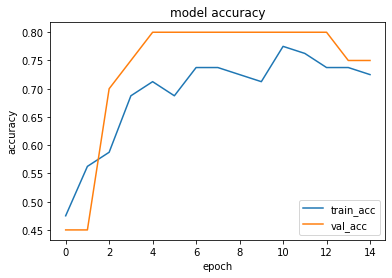

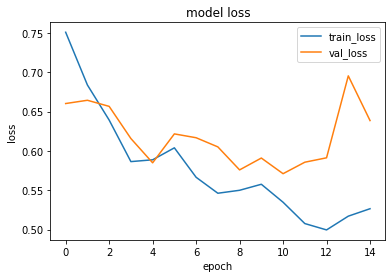

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.4644459]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.5040502]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.61046165]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.43326774]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.3892275]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.3618865]]
Epoch 1/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6755 - accuracy: 0.5500 - precision_242: 0.5273 - recall_242: 0.7436 - val_loss: 0.5952 - val_accuracy: 0.7500 - val_precision_242: 0.7143 - val_recall_242: 0.9091
Epoch 2/75
3/3 [==============================] - 1s 310ms/step - loss: 0.7146 - accuracy: 0.6500 - precision_242: 0.6222 - recall_242: 0.7179 - val_loss: 0.6319 - val_accuracy: 0.5000 - val_precision_242: 1.0000 - val_recall_242: 0.0909
Epoch 3/75
3/3 [==============================] - 1s 312ms/step - loss: 0.6589 - accuracy: 0.6125 - precision_242: 0.6667 - recall_242: 0.4103 - val_loss: 0.5917 - val_accuracy: 0.7500 - val_precision_242: 0.7500 - val_recall_242: 0.8182
Epoch 4/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6262 - accuracy: 0.6375 - precision_242: 0.6562 - recall_242: 0.5385 - val_loss: 0.5666 - val_accuracy: 0.8000 - val_precision_242: 0.7692 - val_recall_242: 0.9

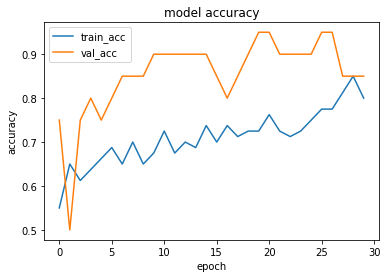

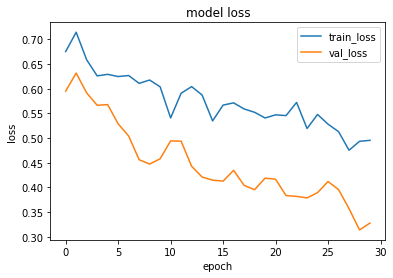

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.43157977]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.523346]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.64315236]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.27612174]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.24697948]]


1it [00:00, 17848.10it/s]

prediction for video control_3.mov is [[0.23954034]]


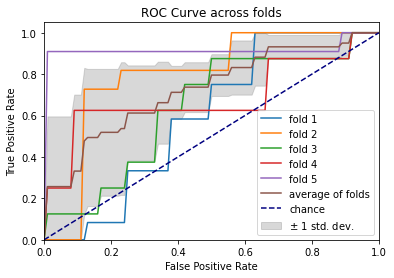

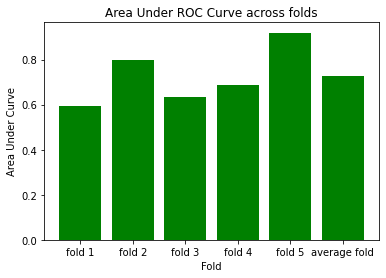

In [125]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 369ms/step - loss: 0.6895 - accuracy: 0.6125 - precision_244: 0.5897 - recall_244: 0.6053 - val_loss: 0.7582 - val_accuracy: 0.5500 - val_precision_244: 0.6000 - val_recall_244: 0.7500
Epoch 2/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6190 - accuracy: 0.7125 - precision_244: 0.6531 - recall_244: 0.8421 - val_loss: 0.6781 - val_accuracy: 0.6000 - val_precision_244: 0.6429 - val_recall_244: 0.7500
Epoch 3/75
3/3 [==============================] - 1s 326ms/step - loss: 0.5464 - accuracy: 0.7250 - precision_244: 0.6905 - recall_244: 0.7632 - val_loss: 0.8212 - val_accuracy: 0.6000 - val_precision_244: 0.6429 - val_recall_244: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 308ms/step - loss: 0.5524 - accuracy: 0.7500 - precision_244: 0.7500 - recall_244: 0.7105 - val_loss: 0.8194 - val_accuracy: 0.6000 - val_precision_244: 0.6667 - val_recall_244: 0.6667
Epoch 5/75
3/3 [==============================] 

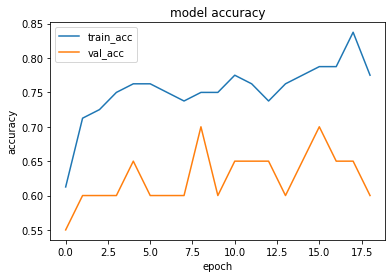

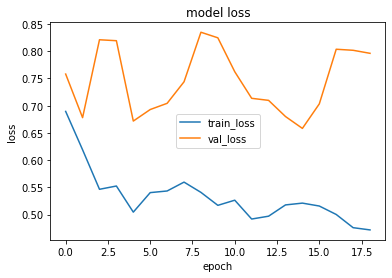

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.29044756]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.69005454]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.7445981]]


1it [00:00, 5203.85it/s]


prediction for video control_1.mov is [[0.05611908]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.0505459]]


1it [00:00, 5785.25it/s]


prediction for video control_3.mov is [[0.06370279]]
Epoch 1/75
3/3 [==============================] - 1s 328ms/step - loss: 0.6966 - accuracy: 0.5875 - precision_245: 0.5882 - recall_245: 0.5128 - val_loss: 0.6247 - val_accuracy: 0.7500 - val_precision_245: 0.7500 - val_recall_245: 0.8182
Epoch 2/75
3/3 [==============================] - 1s 323ms/step - loss: 0.6533 - accuracy: 0.6625 - precision_245: 0.6111 - recall_245: 0.8462 - val_loss: 0.5919 - val_accuracy: 0.7500 - val_precision_245: 0.7500 - val_recall_245: 0.8182
Epoch 3/75
3/3 [==============================] - 1s 319ms/step - loss: 0.6002 - accuracy: 0.6625 - precision_245: 0.6500 - recall_245: 0.6667 - val_loss: 0.6621 - val_accuracy: 0.6000 - val_precision_245: 0.8000 - val_recall_245: 0.3636
Epoch 4/75
3/3 [==============================] - 1s 313ms/step - loss: 0.5875 - accuracy: 0.6750 - precision_245: 0.6757 - recall_245: 0.6410 - val_loss: 0.6357 - val_accuracy: 0.5500 - val_precision_245: 0.6667 - val_recall_245: 0.

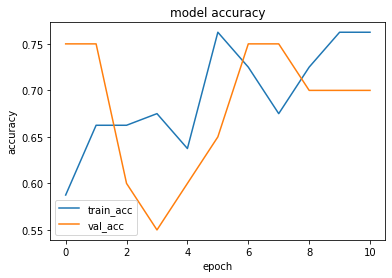

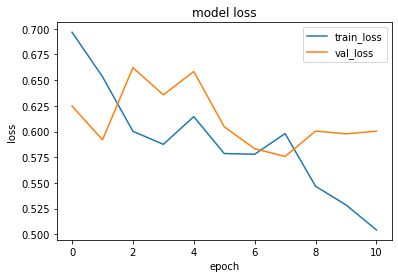

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.49906063]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_3.mov is [[0.53093815]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.5420999]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.47177148]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.46236962]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.45870847]]
Epoch 1/75
3/3 [==============================] - 1s 321ms/step - loss: 0.7750 - accuracy: 0.3500 - precision_246: 0.3438 - recall_246: 0.2619 - val_loss: 0.6917 - val_accuracy: 0.4500 - val_precision_246: 0.4211 - val_recall_246: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6784 - accuracy: 0.5375 - precision_246: 0.5325 - recall_246: 0.9762 - val_loss: 0.6958 - val_accuracy: 0.4000 - val_precision_246: 0.4000 - val_recall_246: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 355ms/step - loss: 0.6549 - accuracy: 0.6250 - precision_246: 0.5968 - recall_246: 0.8810 - val_loss: 0.6742 - val_accuracy: 0.6500 - val_precision_246: 0.5556 - val_recall_246: 0.6250
Epoch 4/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6474 - accuracy: 0.7000 - precision_246: 0.6957 - recall_246: 0.7619 - val_loss: 0.6216 - val_accuracy: 0.6500 - val_precision_246: 0.5714 - val_recall_246: 0.

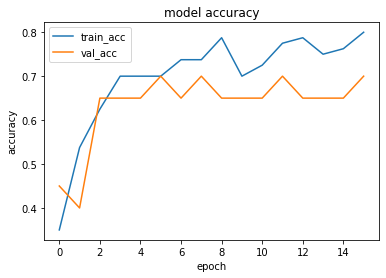

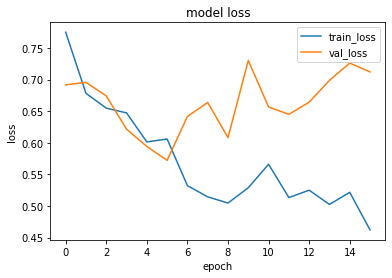

1it [00:00, 12372.58it/s]


prediction for video armflapping_1.mov is [[0.6155348]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.64793396]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.71691245]]


1it [00:00, 17260.51it/s]


prediction for video control_1.mov is [[0.31318104]]


1it [00:00, 18808.54it/s]


prediction for video control_2.mov is [[0.24345076]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.23447052]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6964 - accuracy: 0.5125 - precision_247: 0.5600 - recall_247: 0.3333 - val_loss: 0.7007 - val_accuracy: 0.4000 - val_precision_247: 0.4000 - val_recall_247: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 293ms/step - loss: 0.7152 - accuracy: 0.5375 - precision_247: 0.5316 - recall_247: 1.0000 - val_loss: 0.6511 - val_accuracy: 0.7500 - val_precision_247: 0.7143 - val_recall_247: 0.6250
Epoch 3/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6793 - accuracy: 0.6375 - precision_247: 0.7407 - recall_247: 0.4762 - val_loss: 0.6742 - val_accuracy: 0.6500 - val_precision_247: 0.6000 - val_recall_247: 0.3750
Epoch 4/75
3/3 [==============================] - 1s 292ms/step - loss: 0.6469 - accuracy: 0.6375 - precision_247: 0.6512 - recall_247: 0.6667 - val_loss: 0.6507 - val_accuracy: 0.7000 - val_precision_247: 0.6250 - val_recall_247: 0.

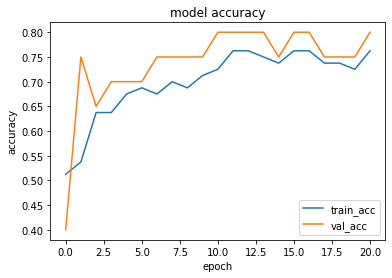

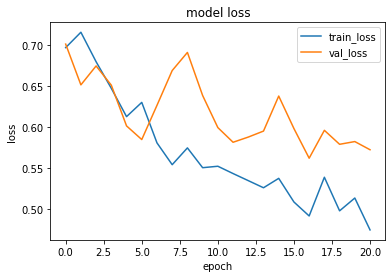

1it [00:00, 14217.98it/s]


prediction for video armflapping_1.mov is [[0.59094834]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.4058668]]


1it [00:00, 17924.38it/s]


prediction for video armflapping_2.mov is [[0.6728481]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.47381288]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.32845032]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.32467538]]
Epoch 1/75
3/3 [==============================] - 1s 318ms/step - loss: 0.7319 - accuracy: 0.6000 - precision_248: 0.5593 - recall_248: 0.8462 - val_loss: 0.6206 - val_accuracy: 0.7000 - val_precision_248: 1.0000 - val_recall_248: 0.4545
Epoch 2/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6926 - accuracy: 0.5750 - precision_248: 0.7273 - recall_248: 0.2051 - val_loss: 0.6098 - val_accuracy: 0.8000 - val_precision_248: 1.0000 - val_recall_248: 0.6364
Epoch 3/75
3/3 [==============================] - 1s 363ms/step - loss: 0.6549 - accuracy: 0.6250 - precision_248: 0.6957 - recall_248: 0.4103 - val_loss: 0.6160 - val_accuracy: 0.8000 - val_precision_248: 0.7692 - val_recall_248: 0.9091
Epoch 4/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6455 - accuracy: 0.6750 - precision_248: 0.6667 - recall_248: 0.6667 - val_loss: 0.6132 - val_accuracy: 0.7000 - val_precision_248: 0.6667 - val_recall_248: 0.

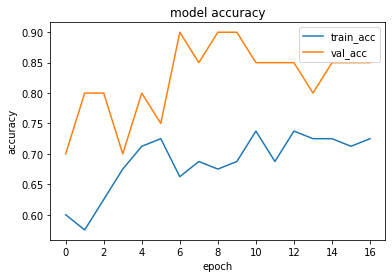

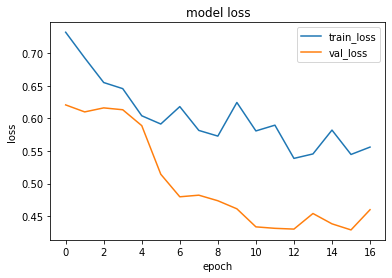

1it [00:00, 17848.10it/s]


prediction for video armflapping_1.mov is [[0.5195217]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.59978044]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.6151702]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.4061054]]


1it [00:00, 16320.25it/s]


prediction for video control_2.mov is [[0.3598369]]


1it [00:00, 17331.83it/s]

prediction for video control_3.mov is [[0.34195006]]


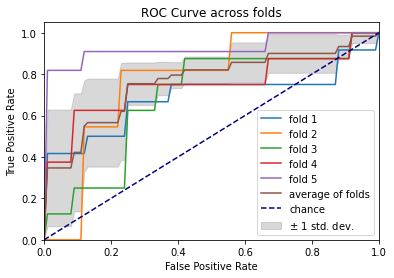

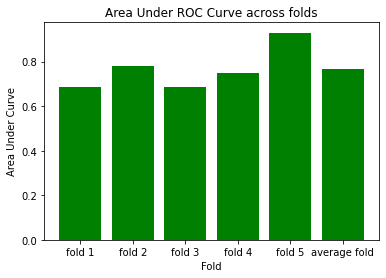

In [126]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 306ms/step - loss: 0.7520 - accuracy: 0.5625 - precision_250: 0.6000 - recall_250: 0.2368 - val_loss: 0.6905 - val_accuracy: 0.6000 - val_precision_250: 0.6000 - val_recall_250: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6581 - accuracy: 0.5625 - precision_250: 0.5224 - recall_250: 0.9211 - val_loss: 0.6937 - val_accuracy: 0.6000 - val_precision_250: 0.6429 - val_recall_250: 0.7500
Epoch 3/75
3/3 [==============================] - 1s 322ms/step - loss: 0.5980 - accuracy: 0.7375 - precision_250: 0.6889 - recall_250: 0.8158 - val_loss: 0.7767 - val_accuracy: 0.5000 - val_precision_250: 0.5714 - val_recall_250: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6025 - accuracy: 0.7000 - precision_250: 0.6591 - recall_250: 0.7632 - val_loss: 0.8199 - val_accuracy: 0.6500 - val_precision_250: 0.6923 - val_recall_250: 0.7500
Epoch 5/75
3/3 [==============================] 

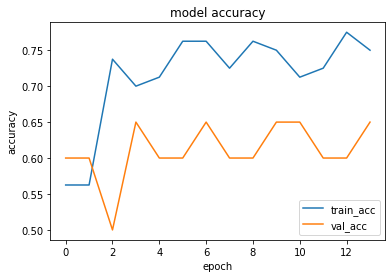

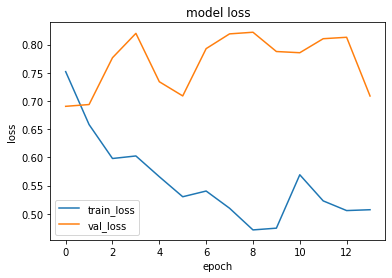

1it [00:00, 18477.11it/s]


prediction for video armflapping_1.mov is [[0.13910434]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.49478254]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.48862037]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.1110445]]


1it [00:00, 18236.10it/s]


prediction for video control_2.mov is [[0.10537386]]


1it [00:00, 20068.44it/s]


prediction for video control_3.mov is [[0.1095269]]
Epoch 1/75
3/3 [==============================] - 1s 301ms/step - loss: 0.7359 - accuracy: 0.4625 - precision_251: 0.4167 - recall_251: 0.2564 - val_loss: 0.6460 - val_accuracy: 0.7500 - val_precision_251: 0.7500 - val_recall_251: 0.8182
Epoch 2/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6647 - accuracy: 0.6125 - precision_251: 0.6250 - recall_251: 0.5128 - val_loss: 0.6552 - val_accuracy: 0.5500 - val_precision_251: 0.7500 - val_recall_251: 0.2727
Epoch 3/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6613 - accuracy: 0.6375 - precision_251: 0.6923 - recall_251: 0.4615 - val_loss: 0.6198 - val_accuracy: 0.8500 - val_precision_251: 0.9000 - val_recall_251: 0.8182
Epoch 4/75
3/3 [==============================] - 1s 354ms/step - loss: 0.6247 - accuracy: 0.7000 - precision_251: 0.6829 - recall_251: 0.7179 - val_loss: 0.5884 - val_accuracy: 0.7500 - val_precision_251: 0.7500 - val_recall_251: 0.8

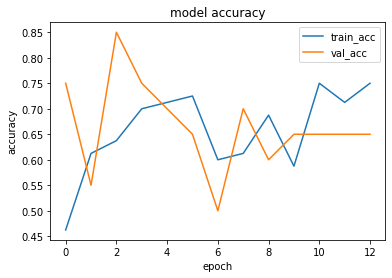

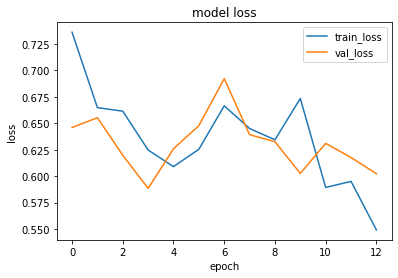

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.48605323]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.51212084]]


1it [00:00, 11366.68it/s]


prediction for video armflapping_2.mov is [[0.5302841]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.45984536]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.44882232]]


1it [00:00, 18236.10it/s]


prediction for video control_3.mov is [[0.44431847]]
Epoch 1/75
3/3 [==============================] - 1s 305ms/step - loss: 0.6640 - accuracy: 0.6250 - precision_252: 0.6304 - recall_252: 0.6905 - val_loss: 0.6687 - val_accuracy: 0.4500 - val_precision_252: 0.4211 - val_recall_252: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 332ms/step - loss: 0.6314 - accuracy: 0.6625 - precision_252: 0.6364 - recall_252: 0.8333 - val_loss: 0.6618 - val_accuracy: 0.6500 - val_precision_252: 0.6667 - val_recall_252: 0.2500
Epoch 3/75
3/3 [==============================] - 1s 427ms/step - loss: 0.6162 - accuracy: 0.7000 - precision_252: 0.7812 - recall_252: 0.5952 - val_loss: 0.6649 - val_accuracy: 0.7500 - val_precision_252: 0.6667 - val_recall_252: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 357ms/step - loss: 0.5796 - accuracy: 0.7750 - precision_252: 0.8158 - recall_252: 0.7381 - val_loss: 0.6957 - val_accuracy: 0.6000 - val_precision_252: 0.5000 - val_recall_252: 0.

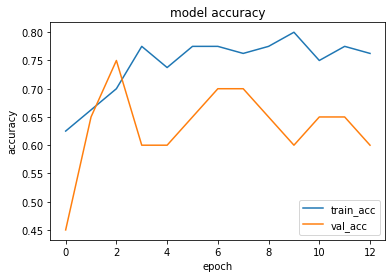

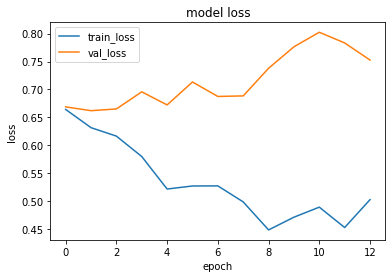

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.46541893]]


1it [00:00, 18315.74it/s]


prediction for video armflapping_3.mov is [[0.7538896]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.6371035]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.3996476]]


1it [00:00, 17331.83it/s]


prediction for video control_2.mov is [[0.36552462]]


1it [00:00, 13025.79it/s]


prediction for video control_3.mov is [[0.35124218]]
Epoch 1/75
3/3 [==============================] - 1s 299ms/step - loss: 0.6974 - accuracy: 0.4125 - precision_253: 0.4324 - recall_253: 0.3810 - val_loss: 0.6765 - val_accuracy: 0.4000 - val_precision_253: 0.3889 - val_recall_253: 0.8750
Epoch 2/75
3/3 [==============================] - 1s 290ms/step - loss: 0.6364 - accuracy: 0.5500 - precision_253: 0.5429 - recall_253: 0.9048 - val_loss: 0.7647 - val_accuracy: 0.7000 - val_precision_253: 1.0000 - val_recall_253: 0.2500
Epoch 3/75
3/3 [==============================] - 1s 313ms/step - loss: 0.6583 - accuracy: 0.6125 - precision_253: 0.6170 - recall_253: 0.6905 - val_loss: 0.6659 - val_accuracy: 0.8000 - val_precision_253: 0.8333 - val_recall_253: 0.6250
Epoch 4/75
3/3 [==============================] - 1s 297ms/step - loss: 0.6078 - accuracy: 0.6875 - precision_253: 0.6735 - recall_253: 0.7857 - val_loss: 0.6673 - val_accuracy: 0.7500 - val_precision_253: 0.8000 - val_recall_253: 0.

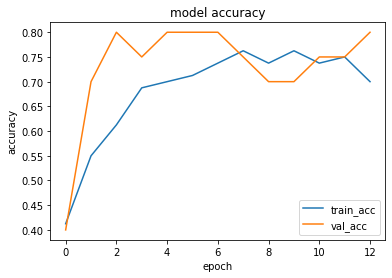

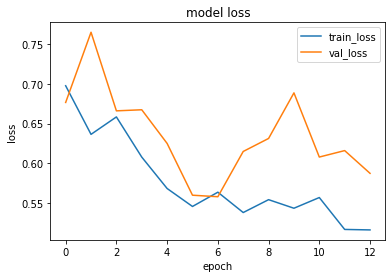

1it [00:00, 19691.57it/s]


prediction for video armflapping_1.mov is [[0.6633229]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.74529696]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.75789523]]


1it [00:00, 17772.47it/s]


prediction for video control_1.mov is [[0.49196467]]


1it [00:00, 17331.83it/s]


prediction for video control_2.mov is [[0.41535354]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.37658763]]
Epoch 1/75
3/3 [==============================] - 1s 321ms/step - loss: 0.7216 - accuracy: 0.4750 - precision_254: 0.4737 - recall_254: 0.6923 - val_loss: 0.6348 - val_accuracy: 0.8000 - val_precision_254: 1.0000 - val_recall_254: 0.6364
Epoch 2/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6935 - accuracy: 0.5875 - precision_254: 0.7500 - recall_254: 0.2308 - val_loss: 0.6121 - val_accuracy: 0.7500 - val_precision_254: 1.0000 - val_recall_254: 0.5455
Epoch 3/75
3/3 [==============================] - 1s 287ms/step - loss: 0.6443 - accuracy: 0.6500 - precision_254: 0.7037 - recall_254: 0.4872 - val_loss: 0.5831 - val_accuracy: 0.7500 - val_precision_254: 0.7143 - val_recall_254: 0.9091
Epoch 4/75
3/3 [==============================] - 1s 355ms/step - loss: 0.6418 - accuracy: 0.6250 - precision_254: 0.5849 - recall_254: 0.7949 - val_loss: 0.5790 - val_accuracy: 0.7500 - val_precision_254: 0.7143 - val_recall_254: 0.

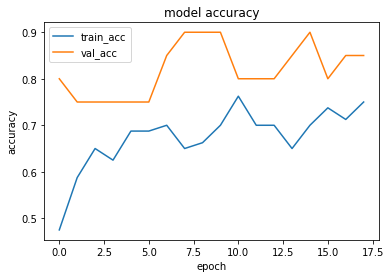

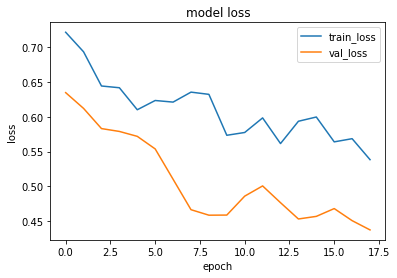

1it [00:00, 17476.27it/s]


prediction for video armflapping_1.mov is [[0.47163814]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.5538281]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.6255514]]


1it [00:00, 14563.56it/s]


prediction for video control_1.mov is [[0.33297962]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.3081248]]


1it [00:00, 18157.16it/s]

prediction for video control_3.mov is [[0.3041218]]


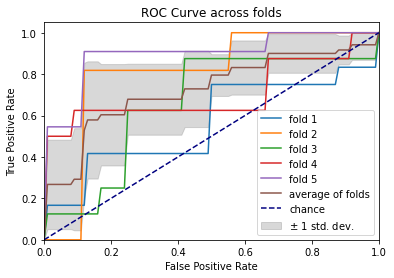

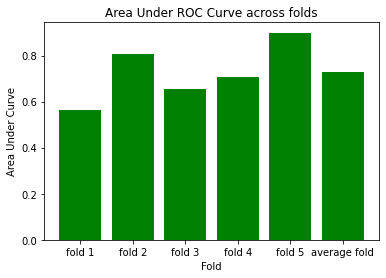

In [127]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 376ms/step - loss: 0.7203 - accuracy: 0.4250 - precision_256: 0.4375 - recall_256: 0.7368 - val_loss: 0.6771 - val_accuracy: 0.5500 - val_precision_256: 0.6667 - val_recall_256: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6329 - accuracy: 0.7375 - precision_256: 0.7742 - recall_256: 0.6316 - val_loss: 0.6709 - val_accuracy: 0.4500 - val_precision_256: 0.5455 - val_recall_256: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 327ms/step - loss: 0.6114 - accuracy: 0.7250 - precision_256: 0.6818 - recall_256: 0.7895 - val_loss: 0.7471 - val_accuracy: 0.5500 - val_precision_256: 0.6364 - val_recall_256: 0.5833
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.5522 - accuracy: 0.7375 - precision_256: 0.7179 - recall_256: 0.7368 - val_loss: 0.8185 - val_accuracy: 0.5500 - val_precision_256: 0.6364 - val_recall_256: 0.5833
Epoch 5/75
3/3 [==============================] 

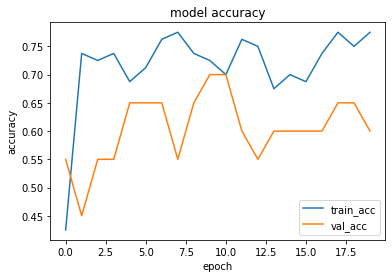

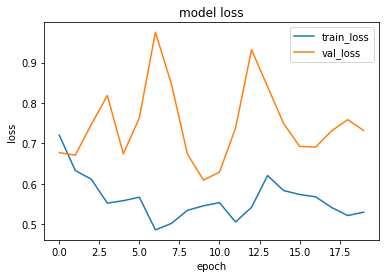

1it [00:00, 17331.83it/s]


prediction for video armflapping_1.mov is [[0.429379]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_3.mov is [[0.44316986]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.52110565]]


1it [00:00, 18558.87it/s]


prediction for video control_1.mov is [[0.34791905]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.30585998]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.29327905]]
Epoch 1/75
3/3 [==============================] - 1s 314ms/step - loss: 0.7310 - accuracy: 0.4500 - precision_257: 0.4627 - recall_257: 0.7949 - val_loss: 0.6388 - val_accuracy: 0.7000 - val_precision_257: 0.7273 - val_recall_257: 0.7273
Epoch 2/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6697 - accuracy: 0.6750 - precision_257: 0.6857 - recall_257: 0.6154 - val_loss: 0.6178 - val_accuracy: 0.7500 - val_precision_257: 0.8750 - val_recall_257: 0.6364
Epoch 3/75
3/3 [==============================] - 1s 309ms/step - loss: 0.6232 - accuracy: 0.7125 - precision_257: 0.7105 - recall_257: 0.6923 - val_loss: 0.5501 - val_accuracy: 0.6500 - val_precision_257: 0.6429 - val_recall_257: 0.8182
Epoch 4/75
3/3 [==============================] - 1s 305ms/step - loss: 0.5757 - accuracy: 0.7125 - precision_257: 0.6818 - recall_257: 0.7692 - val_loss: 0.6445 - val_accuracy: 0.5500 - val_precision_257: 0.6667 - val_recall_257: 0.

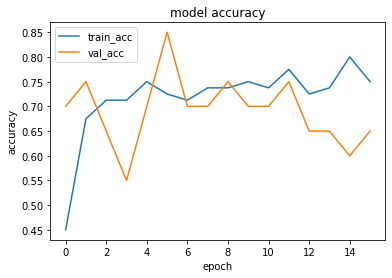

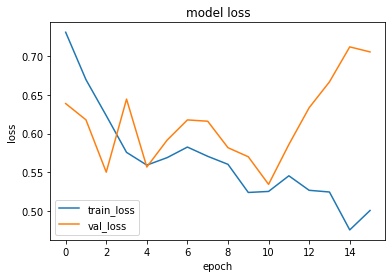

1it [00:00, 16384.00it/s]


prediction for video armflapping_1.mov is [[0.5192801]]


1it [00:00, 17623.13it/s]


prediction for video armflapping_3.mov is [[0.49368054]]


1it [00:00, 17331.83it/s]


prediction for video armflapping_2.mov is [[0.5978009]]


1it [00:00, 14217.98it/s]


prediction for video control_1.mov is [[0.4775349]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.34906858]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.4279198]]
Epoch 1/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6625 - accuracy: 0.5250 - precision_258: 0.5476 - recall_258: 0.5476 - val_loss: 0.7371 - val_accuracy: 0.4000 - val_precision_258: 0.3889 - val_recall_258: 0.8750
Epoch 2/75
3/3 [==============================] - 1s 311ms/step - loss: 0.6476 - accuracy: 0.7000 - precision_258: 0.6731 - recall_258: 0.8333 - val_loss: 0.7134 - val_accuracy: 0.7000 - val_precision_258: 0.6000 - val_recall_258: 0.7500
Epoch 3/75
3/3 [==============================] - 1s 355ms/step - loss: 0.5720 - accuracy: 0.7250 - precision_258: 0.7778 - recall_258: 0.6667 - val_loss: 0.7213 - val_accuracy: 0.6500 - val_precision_258: 0.5556 - val_recall_258: 0.6250
Epoch 4/75
3/3 [==============================] - 1s 303ms/step - loss: 0.5109 - accuracy: 0.7500 - precision_258: 0.7750 - recall_258: 0.7381 - val_loss: 0.7097 - val_accuracy: 0.6500 - val_precision_258: 0.5556 - val_recall_258: 0.6

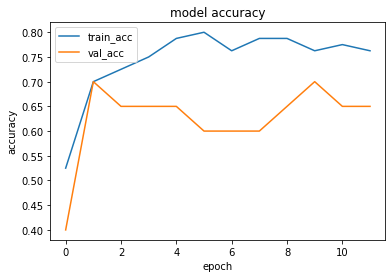

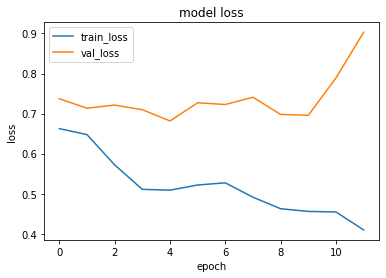

1it [00:00, 17549.39it/s]


prediction for video armflapping_1.mov is [[0.0838927]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.90433514]]


1it [00:00, 11618.57it/s]


prediction for video armflapping_2.mov is [[0.7593156]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.4692662]]


1it [00:00, 18477.11it/s]


prediction for video control_2.mov is [[0.56327677]]


1it [00:00, 17623.13it/s]


prediction for video control_3.mov is [[0.39711314]]
Epoch 1/75
3/3 [==============================] - 1s 293ms/step - loss: 0.7037 - accuracy: 0.5500 - precision_259: 0.5536 - recall_259: 0.7381 - val_loss: 0.6644 - val_accuracy: 0.4000 - val_precision_259: 0.3889 - val_recall_259: 0.8750
Epoch 2/75
3/3 [==============================] - 1s 287ms/step - loss: 0.6567 - accuracy: 0.5875 - precision_259: 0.5634 - recall_259: 0.9524 - val_loss: 0.6973 - val_accuracy: 0.6500 - val_precision_259: 0.6667 - val_recall_259: 0.2500
Epoch 3/75
3/3 [==============================] - 1s 291ms/step - loss: 0.6712 - accuracy: 0.5750 - precision_259: 0.6818 - recall_259: 0.3571 - val_loss: 0.6846 - val_accuracy: 0.7000 - val_precision_259: 0.7500 - val_recall_259: 0.3750
Epoch 4/75
3/3 [==============================] - 1s 351ms/step - loss: 0.6270 - accuracy: 0.7375 - precision_259: 0.7442 - recall_259: 0.7619 - val_loss: 0.6213 - val_accuracy: 0.7500 - val_precision_259: 0.7143 - val_recall_259: 0.

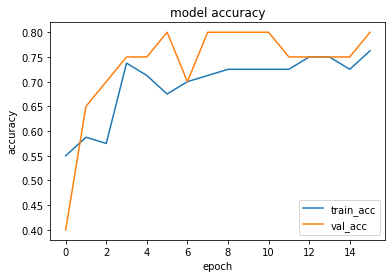

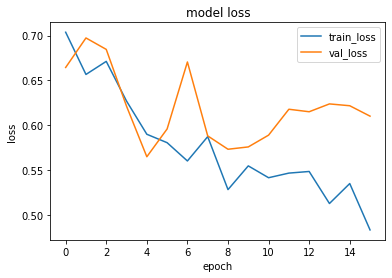

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.4986516]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.6011576]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.68629926]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.33589163]]


1it [00:00, 16384.00it/s]


prediction for video control_2.mov is [[0.37030268]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.30728155]]
Epoch 1/75
3/3 [==============================] - 1s 297ms/step - loss: 0.7145 - accuracy: 0.5500 - precision_260: 0.5429 - recall_260: 0.4872 - val_loss: 0.6583 - val_accuracy: 0.7000 - val_precision_260: 0.6667 - val_recall_260: 0.9091
Epoch 2/75
3/3 [==============================] - 1s 289ms/step - loss: 0.6954 - accuracy: 0.6500 - precision_260: 0.6078 - recall_260: 0.7949 - val_loss: 0.6070 - val_accuracy: 0.7000 - val_precision_260: 0.6667 - val_recall_260: 0.9091
Epoch 3/75
3/3 [==============================] - 1s 284ms/step - loss: 0.6511 - accuracy: 0.6250 - precision_260: 0.6364 - recall_260: 0.5385 - val_loss: 0.5687 - val_accuracy: 0.8500 - val_precision_260: 0.8333 - val_recall_260: 0.9091
Epoch 4/75
3/3 [==============================] - 1s 361ms/step - loss: 0.5996 - accuracy: 0.7375 - precision_260: 0.7368 - recall_260: 0.7179 - val_loss: 0.5595 - val_accuracy: 0.8000 - val_precision_260: 0.7692 - val_recall_260: 0.

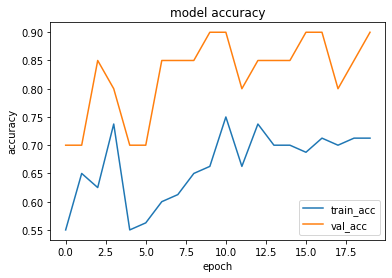

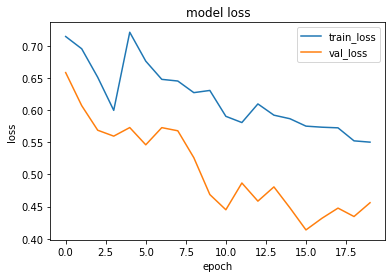

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.5101485]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.57444215]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_2.mov is [[0.5705083]]


1it [00:00, 17623.13it/s]


prediction for video control_1.mov is [[0.4577241]]


1it [00:00, 16912.52it/s]


prediction for video control_2.mov is [[0.42528525]]


1it [00:00, 16131.94it/s]

prediction for video control_3.mov is [[0.4066373]]


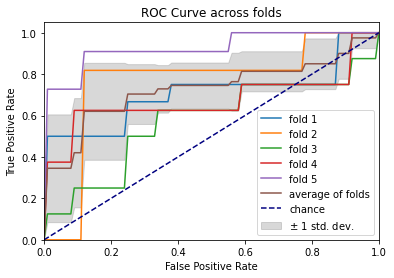

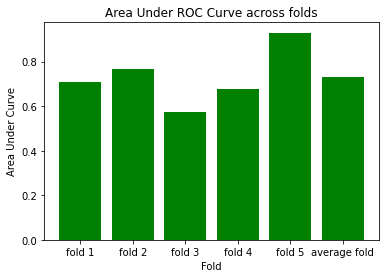

In [128]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

Epoch 1/75
3/3 [==============================] - 1s 316ms/step - loss: 0.6990 - accuracy: 0.4625 - precision_262: 0.4490 - recall_262: 0.5789 - val_loss: 0.6778 - val_accuracy: 0.6000 - val_precision_262: 0.7500 - val_recall_262: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6615 - accuracy: 0.6625 - precision_262: 0.6571 - recall_262: 0.6053 - val_loss: 0.6657 - val_accuracy: 0.5500 - val_precision_262: 0.6667 - val_recall_262: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6210 - accuracy: 0.6875 - precision_262: 0.6857 - recall_262: 0.6316 - val_loss: 0.6481 - val_accuracy: 0.6000 - val_precision_262: 0.6667 - val_recall_262: 0.6667
Epoch 4/75
3/3 [==============================] - 1s 308ms/step - loss: 0.5643 - accuracy: 0.7375 - precision_262: 0.6889 - recall_262: 0.8158 - val_loss: 1.0101 - val_accuracy: 0.6000 - val_precision_262: 0.6667 - val_recall_262: 0.6667
Epoch 5/75
3/3 [==============================] 

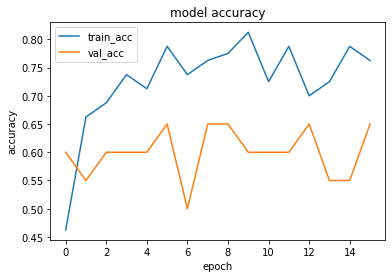

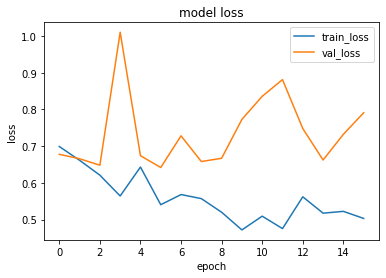

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.44260964]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.47035658]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.5007465]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.38115746]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.3648355]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.34734768]]
Epoch 1/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6992 - accuracy: 0.4625 - precision_263: 0.4600 - recall_263: 0.5897 - val_loss: 0.6740 - val_accuracy: 0.6000 - val_precision_263: 0.6000 - val_recall_263: 0.8182
Epoch 2/75
3/3 [==============================] - 1s 310ms/step - loss: 0.6839 - accuracy: 0.7250 - precision_263: 0.6809 - recall_263: 0.8205 - val_loss: 0.6366 - val_accuracy: 0.7000 - val_precision_263: 0.6923 - val_recall_263: 0.8182
Epoch 3/75
3/3 [==============================] - 1s 320ms/step - loss: 0.6568 - accuracy: 0.7000 - precision_263: 0.6667 - recall_263: 0.7692 - val_loss: 0.5794 - val_accuracy: 0.7000 - val_precision_263: 0.6923 - val_recall_263: 0.8182
Epoch 4/75
3/3 [==============================] - 1s 368ms/step - loss: 0.5978 - accuracy: 0.6875 - precision_263: 0.6750 - recall_263: 0.6923 - val_loss: 0.5807 - val_accuracy: 0.6500 - val_precision_263: 0.6667 - val_recall_263: 0.

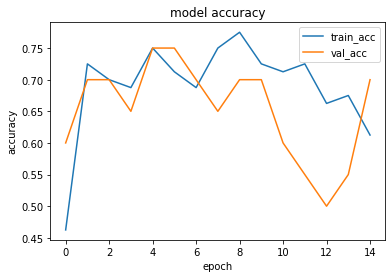

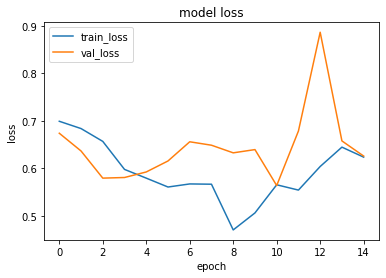

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.4420429]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.58853537]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_2.mov is [[0.55755013]]


1it [00:00, 17772.47it/s]


prediction for video control_1.mov is [[0.42279232]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.37613544]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.40560943]]
Epoch 1/75
3/3 [==============================] - 1s 370ms/step - loss: 0.6954 - accuracy: 0.5375 - precision_264: 0.5676 - recall_264: 0.5000 - val_loss: 0.6817 - val_accuracy: 0.4500 - val_precision_264: 0.4211 - val_recall_264: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 306ms/step - loss: 0.6531 - accuracy: 0.6125 - precision_264: 0.5797 - recall_264: 0.9524 - val_loss: 0.6552 - val_accuracy: 0.7000 - val_precision_264: 0.5714 - val_recall_264: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 308ms/step - loss: 0.6056 - accuracy: 0.7250 - precision_264: 0.7381 - recall_264: 0.7381 - val_loss: 0.6536 - val_accuracy: 0.6000 - val_precision_264: 0.5000 - val_recall_264: 0.7500
Epoch 4/75
3/3 [==============================] - 1s 306ms/step - loss: 0.5406 - accuracy: 0.7500 - precision_264: 0.7619 - recall_264: 0.7619 - val_loss: 0.6554 - val_accuracy: 0.6000 - val_precision_264: 0.5000 - val_recall_264: 0.

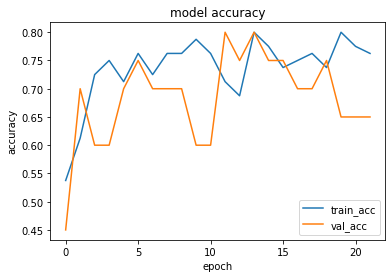

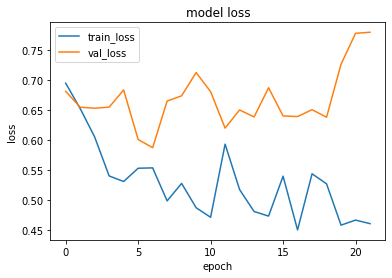

1it [00:00, 14979.66it/s]


prediction for video armflapping_1.mov is [[0.56152344]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.36819384]]


1it [00:00, 17260.51it/s]


prediction for video armflapping_2.mov is [[0.5712633]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.4505551]]


1it [00:00, 15087.42it/s]


prediction for video control_2.mov is [[0.49384582]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.32068568]]
Epoch 1/75
3/3 [==============================] - 1s 387ms/step - loss: 0.6895 - accuracy: 0.5375 - precision_265: 0.5439 - recall_265: 0.7381 - val_loss: 0.6951 - val_accuracy: 0.7000 - val_precision_265: 0.7500 - val_recall_265: 0.3750
Epoch 2/75
3/3 [==============================] - 1s 315ms/step - loss: 0.6499 - accuracy: 0.5750 - precision_265: 0.5909 - recall_265: 0.6190 - val_loss: 0.6839 - val_accuracy: 0.5000 - val_precision_265: 0.4375 - val_recall_265: 0.8750
Epoch 3/75
3/3 [==============================] - 1s 309ms/step - loss: 0.5837 - accuracy: 0.6500 - precision_265: 0.6061 - recall_265: 0.9524 - val_loss: 0.6840 - val_accuracy: 0.7000 - val_precision_265: 0.6250 - val_recall_265: 0.6250
Epoch 4/75
3/3 [==============================] - 1s 304ms/step - loss: 0.5760 - accuracy: 0.6750 - precision_265: 0.6481 - recall_265: 0.8333 - val_loss: 0.6335 - val_accuracy: 0.7500 - val_precision_265: 0.7143 - val_recall_265: 0.

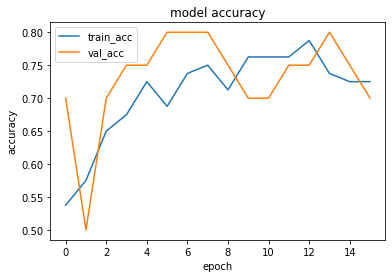

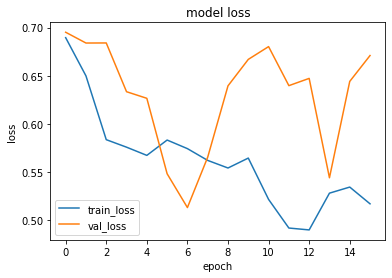

1it [00:00, 15887.52it/s]


prediction for video armflapping_1.mov is [[0.5035275]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.59558505]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.67950505]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.267107]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.2675386]]


1it [00:00, 17189.77it/s]


prediction for video control_3.mov is [[0.2034257]]
Epoch 1/75
3/3 [==============================] - 1s 296ms/step - loss: 0.6981 - accuracy: 0.4125 - precision_266: 0.4200 - recall_266: 0.5385 - val_loss: 0.6119 - val_accuracy: 0.6000 - val_precision_266: 0.6667 - val_recall_266: 0.5455
Epoch 2/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6710 - accuracy: 0.6000 - precision_266: 0.5660 - recall_266: 0.7692 - val_loss: 0.5540 - val_accuracy: 0.8000 - val_precision_266: 0.8182 - val_recall_266: 0.8182
Epoch 3/75
3/3 [==============================] - 1s 285ms/step - loss: 0.6634 - accuracy: 0.6250 - precision_266: 0.6154 - recall_266: 0.6154 - val_loss: 0.5900 - val_accuracy: 0.8500 - val_precision_266: 0.9000 - val_recall_266: 0.8182
Epoch 4/75
3/3 [==============================] - 1s 288ms/step - loss: 0.6210 - accuracy: 0.7000 - precision_266: 0.7273 - recall_266: 0.6154 - val_loss: 0.5491 - val_accuracy: 0.8000 - val_precision_266: 0.7692 - val_recall_266: 0.9

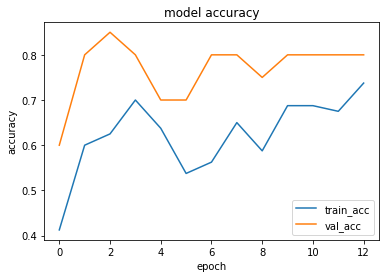

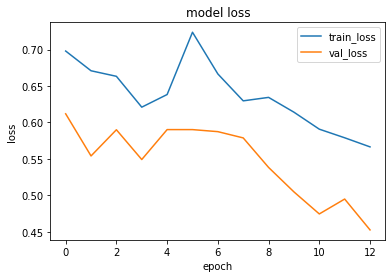

1it [00:00, 12787.51it/s]


prediction for video armflapping_1.mov is [[0.42939416]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_3.mov is [[0.46567616]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.49470234]]


1it [00:00, 11096.04it/s]


prediction for video control_1.mov is [[0.39448598]]


1it [00:00, 17476.27it/s]


prediction for video control_2.mov is [[0.38226867]]


1it [00:00, 18477.11it/s]

prediction for video control_3.mov is [[0.3751284]]


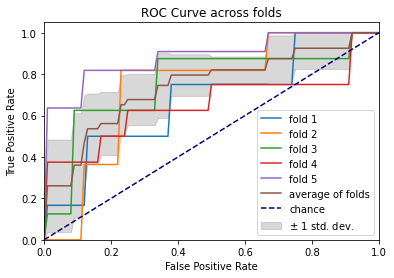

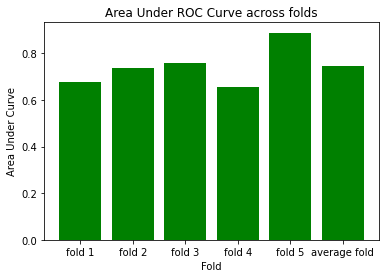

In [129]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

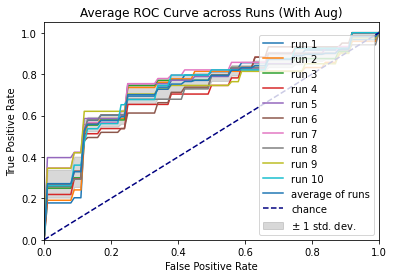

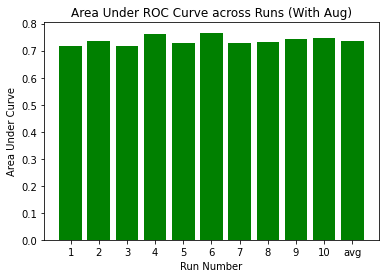

In [139]:
# REEE RUN THIS STUFF 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [140]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

# this is with no augmentation BTW. 

(0.7371376811594204, 0.015126094113643695)